In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Loading metadata...
Done in 5.807781934738159s.
Done.


In [3]:
mean_pop.genes['is_tf'] = mean_pop.genes['gene_name'].isin(mean_pop.cells['target_gene'])

In [4]:
PREFIX = '20240315_fibroblast_unfiltered_atoms'

In [5]:
from sklearn.decomposition._dict_learning import dict_learning
from sklearn.decomposition import SparsePCA

class NonNegativeSparsePCA(SparsePCA):
    def _fit(self, X, n_components, random_state):
        """Specialized 'fit' for Non-Negative SparsePCA."""

        code_init = self.V_init.T if self.V_init is not None else None
        dict_init = self.U_init.T if self.U_init is not None else None

        # Dictionary learning algorithm with non-negative dictionary atoms
        code, dictionary, E, self.n_iter_ = dict_learning(
            X.T,
            n_components,
            alpha=self.alpha,
            tol=self.tol,
            max_iter=self.max_iter,
            method=self.method,
            n_jobs=self.n_jobs,
            verbose=self.verbose,
            random_state=random_state,
            code_init=code_init,
            dict_init=dict_init,
            return_n_iter=True,
            positive_code=True,
        )

        self.components_ = code.T

        # Normalize components
        components_norm = np.linalg.norm(self.components_, axis=1)[:, np.newaxis]
        components_norm[components_norm == 0] = 1
        self.components_ /= components_norm
        self.n_components_ = len(self.components_)

        self.error_ = E
        return self

In [ ]:
n_components=100
alpha=1
n_samples=100

atoms = dict()

for i in tqdm(np.arange(n_samples)):
    bootstrap_sample = expr.sample(n=len(expr), replace=True)

    sparse_pca = NonNegativeSparsePCA(n_components=n_components,  # number of sparse atoms to extract
                       alpha=alpha,  # Sparsity-controlling parameter
                       random_state=None,
                       n_jobs=1, verbose=1, method='cd', max_iter=1000)

    sparse_pca.fit(bootstrap_sample)
    components = pd.DataFrame(sparse_pca.components_, columns=expr.columns)
    
    for name, row in components.iterrows():
        atoms[f"{i}_{name}"] = row
        
atoms = pd.DataFrame(atoms).T
atoms.to_hdf(f"{PREFIX}_{alpha}_{n_components}.hdf", key='atoms')

  0%|          | 0/100 [00:00<?, ?it/s]

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
n_components=100
alpha=2
n_samples=100

atoms = dict()

for i in tqdm(np.arange(n_samples)):
    bootstrap_sample = expr.sample(n=len(expr), replace=True)

    sparse_pca = NonNegativeSparsePCA(n_components=n_components,  # number of sparse atoms to extract
                       alpha=alpha,  # Sparsity-controlling parameter
                       random_state=None,
                       n_jobs=1, verbose=1, method='cd', max_iter=1000)

    sparse_pca.fit(bootstrap_sample)
    components = pd.DataFrame(sparse_pca.components_, columns=expr.columns)
    
    for name, row in components.iterrows():
        atoms[f"{i}_{name}"] = row
        
atoms = pd.DataFrame(atoms).T
atoms.to_hdf(f"{PREFIX}_{alpha}_{n_components}.hdf", key='atoms')

In [ ]:
n_components=100
alpha=1.5
n_samples=100

atoms = dict()

for i in tqdm(np.arange(n_samples)):
    bootstrap_sample = expr.sample(n=len(expr), replace=True)

    sparse_pca = NonNegativeSparsePCA(n_components=n_components,  # number of sparse atoms to extract
                       alpha=alpha,  # Sparsity-controlling parameter
                       random_state=None,
                       n_jobs=1, verbose=1, method='cd', max_iter=1000)

    sparse_pca.fit(bootstrap_sample)
    components = pd.DataFrame(sparse_pca.components_, columns=expr.columns)
    
    for name, row in components.iterrows():
        atoms[f"{i}_{name}"] = row
        
atoms = pd.DataFrame(atoms).T
atoms.to_hdf(f"{PREFIX}_{alpha}_{n_components}.hdf", key='atoms')

In [189]:
file = '20240315_fibroblast_unfiltered_atoms_1_100.hdf'
n_samples = 100
alpha = float(file.split('_')[-2])
n_components = int(file.split('_')[-1].split('.')[0])

atoms = pd.read_hdf(file)

In [210]:
coherence = 0.9

In [211]:
from umap import UMAP
from umap.distances import hellinger
from hdbscan import HDBSCAN

In [212]:
embedding = UMAP(
    n_neighbors=15, n_components=5, metric=hellinger
).fit_transform(atoms)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


In [213]:
clusterer = HDBSCAN(
    min_samples=int(n_samples*coherence),
    min_cluster_size=int(n_samples*coherence),
    cluster_selection_method="leaf",
    allow_single_cluster=True,
).fit(embedding)

In [214]:
labels = clusterer.labels_
membership_strengths = clusterer.probabilities_

result = np.empty((labels.max() + 1, atoms.shape[1]), dtype=np.float32)

for i in range(labels.max() + 1):
    mask = labels == i
    result[i] = (
        np.average(
            np.sqrt(atoms.values[mask]), axis=0, weights=membership_strengths[mask]
        )
        ** 2
    )
    result[i] /= result[i].sum()
    
result = pd.DataFrame(result, columns=atoms.columns)
result = result.div(result.apply(lambda x: np.linalg.norm(x), axis=1), axis=0)

In [215]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(result, metric=hellinger)
Z = linkage(squareform(distance_matrix), method='average')

In [216]:
# def hellinger_distance(u, v):
#     return np.sqrt(np.sum((np.sqrt(u) - np.sqrt(v)) ** 2)) / np.sqrt(2)

# distance_matrix = pairwise_distances(result.T, metric=hellinger_distance)
# Zt = linkage(squareform(distance_matrix), method='average')

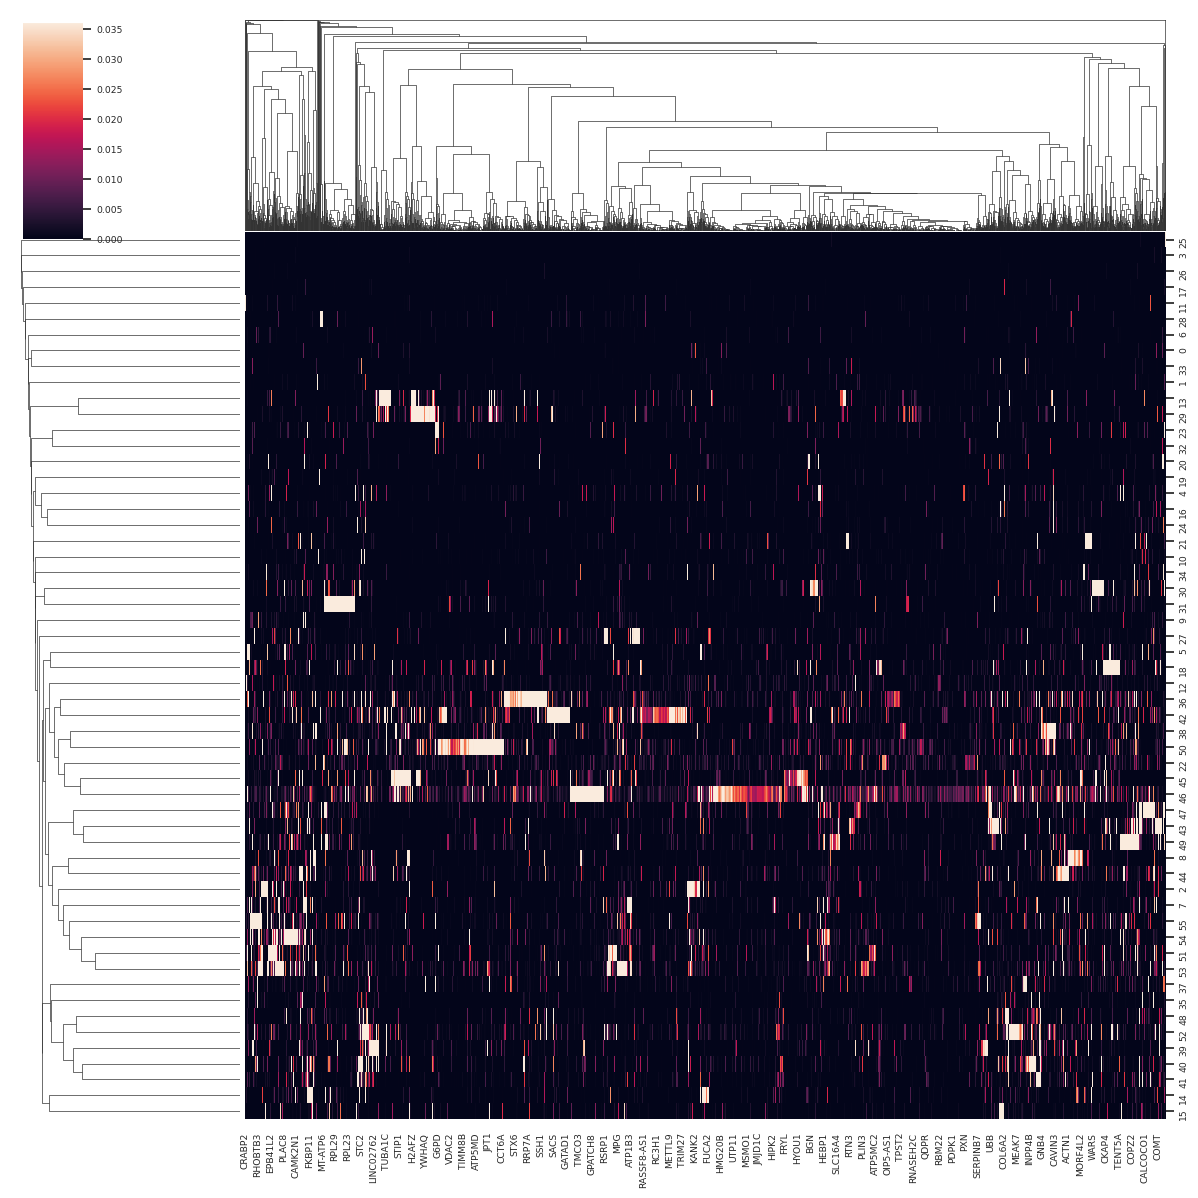

In [217]:
sns.set(font_scale=0.6)
sns.clustermap(result, robust=True, method='ward', row_linkage=Z, figsize=[12,12])

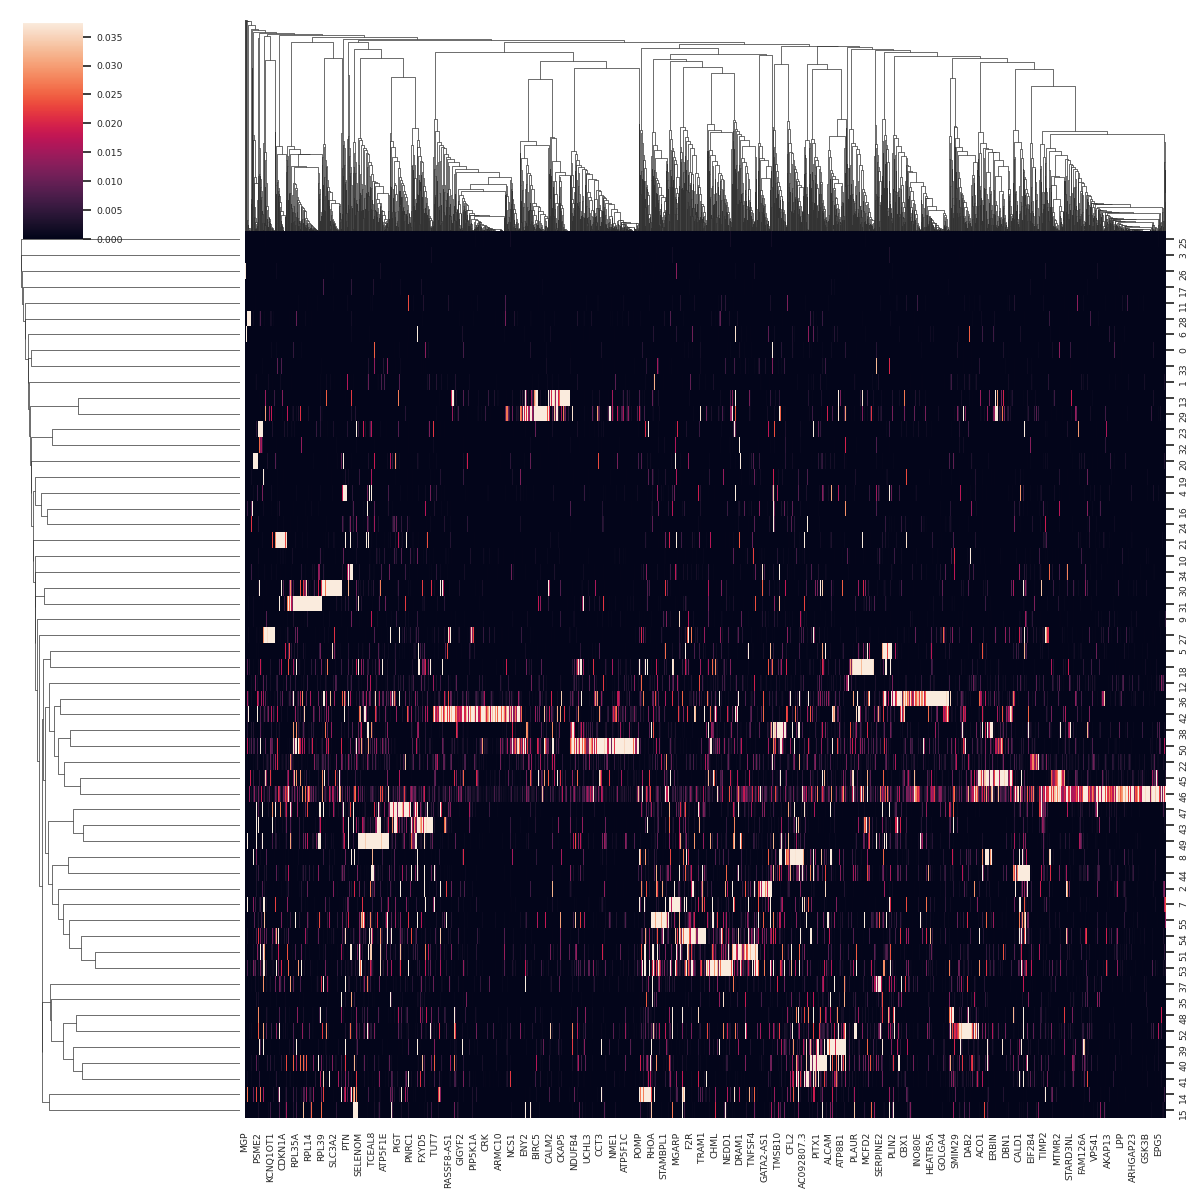

In [218]:
sns.set(font_scale=0.6)
sns.clustermap(result.loc[:, result.max()>0.01], robust=True, method='average', metric='cosine', row_linkage=Z, figsize=[12,12])

In [219]:
result

,FUCA2,NIPAL3,ANKIB1,CYP51A1,BAD,LAP3,CD99,TFPI,PLXND1,KDM1A,...,NUDT3,PPP4R3B,PRAG1,ARHGAP23,AC037198.1,PCGF2,MARCKS,PSMB3,EBLN3P,AC092807.3
0,1.234542e-03,0.000000e+00,0.000000e+00,2.033061e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.006271e-08,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.384526e-05,0.000000e+00,0.000000e+00,4.127136e-07,0.000000e+00,0.000000e+00,5.684159e-04
1,0.000000e+00,2.512777e-06,3.023063e-05,6.794324e-07,1.494739e-06,0.000000e+00,0.000000e+00,1.313192e-05,0.000000e+00,0.000000e+00,...,2.193123e-06,6.957235e-05,3.663026e-05,0.000000e+00,1.072738e-04,0.000000e+00,0.000000e+00,0.000000e+00,4.930714e-04,9.900032e-09
2,2.227528e-05,2.178832e-05,3.924816e-07,1.979028e-04,4.472895e-06,0.000000e+00,9.194812e-05,3.816134e-04,2.054485e-03,2.335110e-05,...,3.699960e-06,0.000000e+00,3.517472e-02,0.000000e+00,0.000000e+00,2.167266e-06,1.803173e-01,0.000000e+00,1.069216e-06,0.000000e+00
3,8.430545e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.793225e-07,0.000000e+00,...,1.175874e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4.586288e-04,0.000000e+00,0.000000e+00,1.014583e-03,0.000000e+00,5.514237e-03,0.000000e+00,8.464514e-04,0.000000e+00,0.000000e+00,...,3.112689e-04,9.985987e-06,0.000000e+00,0.000000e+00,0.000000e+00,8.362354e-07,3.219342e-05,0.000000e+00,4.576619e-06,0.000000e+00
5,3.187799e-05,2.695992e-07,4.077267e-06,1.803855e-07,0.000000e+00,1.754209e-06,8.631094e-07,4.012517e-05,0.000000e+00,1.306951e-05,...,1.799854e-05,0.000000e+00,4.741324e-04,0.000000e+00,0.000000e+00,0.000000e+00,3.243154e-02,0.000000e+00,2.782988e-05,0.000000e+00
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.245193e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.492899e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107011e-07,4.655447e-05
7,9.061139e-03,8.058405e-03,2.609028e-07,1.550175e-03,3.534205e-04,5.932491e-06,0.000000e+00,1.217329e-02,3.365313e-03,1.787208e-09,...,5.478549e-04,0.000000e+00,2.537451e-04,2.661251e-04,1.500033e-09,3.230639e-07,8.444287e-02,0.000000e+00,0.000000e+00,0.000000e+00
8,0.000000e+00,1.509997e-07,6.973410e-06,1.385728e-05,0.000000e+00,2.699717e-06,4.215462e-06,0.000000e+00,2.352082e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,1.125446e-07,1.486039e-06,3.457266e-06,0.000000e+00,1.135901e-09,0.000000e+00,0.000000e+00,3.052325e-02
9,8.318680e-06,1.352383e-03,6.294647e-06,5.400299e-06,6.925669e-06,7.103995e-05,4.260555e-05,1.477662e-06,1.725502e-06,1.989705e-06,...,0.000000e+00,3.275993e-06,8.626940e-07,6.315303e-05,9.492767e-07,2.603719e-06,9.843915e-05,2.111401e-05,0.000000e+00,1.951748e-05


In [221]:
from sklearn.linear_model import ridge_regression

X = expr - expr.mean(axis=0)

U = ridge_regression(
            result.T, X.T, 0.01, solver="cholesky"
        )
codes = pd.DataFrame(U, index=expr.index)

In [223]:
maxes = result.T.max()
distributed = maxes[maxes<0.9].index

In [247]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(metric='correlation', min_samples=1, min_cluster_size=2, cluster_selection_method='eom')
clusterer.fit(codes)

HDBSCAN(metric='correlation', min_samples=1)

In [249]:
clusters = pd.Series(clusterer.labels_, index=result.index)

In [250]:
clustered = clusters[clusters != -1]

# Group by cluster label and list the composition of each cluster.
cluster_composition = clustered.groupby(clustered).apply(lambda x: x.index.tolist())
for cluster, composition in cluster_composition.items():
    formatted_composition = '\n'.join(str(index) for index in composition)
    print(f'Cluster {cluster}:\n{formatted_composition}' + '\n')

Cluster 0:
MT-CO2
MT-CYB
MT-ND2
MT-ND5
MT-CO1
MT-ND3
MT-ND4
MT-ND1
MT-ATP6
MT-CO3

Cluster 1:
GCLM
AKR1B1
FTL
PRDX1
TXN
PGD
SLC7A11
G6PD
SQSTM1
TKT
FTH1
HINT1
TALDO1

Cluster 2:
MKNK2
TNNT1
FAM162A
NRP2
DNAJC1
C1R
SEZ6L2
ALPK2

Cluster 3:
ARHGAP10
SLC25A3
FBLN1
RIPK2
MEIS3
PTN
MPST
NES
SNRNP25

Cluster 4:
SYT1
DTWD1
GLT8D2
SPAG16
MMP1

Cluster 5:
CRYAB
IGFBP2
IGFBP5
PRDX6
RPAIN
USP53
TMEM47
SCN9A
KISS1
MFAP5
TXNIP

Cluster 6:
RECK
ANXA1
VEGFC
ALCAM
ROBO2
LPAR1

Cluster 7:
SRPK1
RAB34
EGR1
PDGFRA
MDFIC
SERPINE2
ECM1
GLRX
TRNP1

Cluster 8:
ROCK1
AKT3
TLN1
CRIM1
CAVIN1

Cluster 9:
OPN3
KRT18
HDDC2
TPD52L1
CAP2
ERGIC1
NFYB
RDH10
CISD1
BTBD3
MGARP
GABARAPL1
CUL4B
CYB5A
C1GALT1C1
GATA2
PAPSS2
PSG4

Cluster 10:
FUCA2
MGST1
MRVI1
MGST2
BEX4
BST1
OGFRL1
SRGN
FKBP11
OCIAD2
UCHL1
PDE1C
PLAAT3
METRNL
CADM1
PBX1
LAGE3
LAYN
HSBP1L1
MAP4K3-DT

Cluster 11:
PSME1
PSME2
B2M
PARP14
ISG15
PSMB8
HLA-C
PSMB10
HLA-A
HLA-B
PSMB9

Cluster 12:
ADAMTS2
CDK6
COL1A1
SPARC
P4HA1
COL5A1
LOXL2
COL1A2
FBN1
BMP1
COL3A1

In [238]:
clusters.value_counts().head(20)

-1      9715
 330      87
 205      31
 270      27
 177      25
 190      23
 176      20
 276      16
 129      15
 186      13
 55       12
 73       11
 260      10
 265      10
 109      10
 127      10
 20       10
 238      10
 157       9
 307       9
dtype: int64

In [243]:
clusters[clusters==270].head(50)

guide_identity
CIZ1_GCCTCCGCATCGCGAAGGGG      270
CTNNB1_GGCCGCGCGAGGACAAGGGG    270
DLX2_GGGAACGCCCGGCCAAGGGG      270
ELF5_GACACGGCTCCTTGGAGGGG      270
EMX1_GAGAAGCCAGTGGCGAGGGG      270
EZH1_GAAAGCGGCGCTGGCAGGGG      270
FUBP1_GCCATCGTGCCGTAAAGGGG     270
GLIS2_GAGTCCTGGGGTGCGAGGGG     270
HNF4A_GCCTAGCCTCTGTGAAGGGG     270
LEF1_GTGGCTGCCCGCTGGAGGGG      270
PRDM16_GGAGCTGCGCTGAAAAGGGG    270
PRDM4_GAGGGCGCACGCACGAGGGG     270
PRDM9_GGAGGGACCTTCCTCAGGGG     270
PREB_GTCTGCCTCCGCGCCAGGGG      270
RPA3_GGCGCTGTCTCTGAAAGGGG      270
SIX2_GGGGCGAAGACGAAAAGGGG      270
STAT6_GGGAGCCAGGCAGTTAGGGG     270
TULP3_GCGGGAGGGTTGCTAAGGGG     270
ZNF143_GTGCGCGAGCCACTCAGGGG    270
ZNF536_GGTCCCGGCAGTACCAGGGG    270
ZNF616_GAGCCGCGACCAGCAAGGGG    270
ZNF670_GTCACTCAGGACTGAAGGGG    270
ZNF681_GTCACTCAGGACCTGAGGGG    270
ZNF763_GGTCACTCAGAAGTGAGGGG    270
ZNF799_GTCAATCAGTCCACGAGGGG    270
ZNF823_GTCAATCAGCCACCAAGGGG    270
ZNF860_GTCCCGAGGTGGATAAGGGG    270
dtype: int64

In [168]:
mean_pop.cells.loc['ZHX2_GCGAGCCCGGGTGGCAGCTC']

protospacer                            GCGAGCCCGGGTGGCAGCTC
target_gene                                            ZHX2
target_expr                                             NaN
active                                                False
cluster                                              1147.0
cluster_name                                            NaN
cluster_description                      1147: neither (20)
gene_driven                                           False
sequence_driven                                       False
sequence_suffix                                            
bulk_expr                                          5.776868
expressed                                              True
p_expressed                                        0.997048
de_genes                                              100.0
strength                                          49.305494
cell_count                                            219.0
target_gene_id                          

In [163]:
codes.loc['ZNF829_GCTGGCGCGGAGGGATGGTT'].sort_values()

29   -0.729392
40   -0.728229
12   -0.709066
43   -0.653682
61   -0.627483
        ...   
52    0.672663
44    0.687412
55    0.806595
11    0.976183
30    5.021469
Name: ZNF829_GCTGGCGCGGAGGGATGGTT, Length: 66, dtype: float32

In [244]:
codes.loc[clusters[clusters==270].index].mean().sort_values()

18   -2.454642
50   -2.112026
38   -1.993244
53   -1.329767
52   -1.223518
5    -1.093074
45   -0.986060
29   -0.968276
51   -0.686595
23   -0.678625
13   -0.654603
46   -0.654104
43   -0.614933
42   -0.345934
6    -0.313600
8    -0.287332
27   -0.267383
32   -0.233083
3    -0.226041
36   -0.222964
35   -0.200456
33   -0.197857
28   -0.176061
44   -0.173978
15   -0.142774
48   -0.103968
41   -0.090205
0    -0.079816
14   -0.068211
21   -0.063291
11   -0.046761
55   -0.044757
49    0.036474
17    0.048332
39    0.065299
16    0.068849
26    0.127370
4     0.136957
1     0.299412
19    0.364089
22    0.400150
7     0.406779
9     0.462699
30    0.479817
2     0.485960
37    0.580883
20    0.618212
24    0.725768
40    0.741498
54    0.962585
10    1.078872
12    1.474700
47    2.062312
31    3.532908
25    4.057003
34    4.948888
dtype: float32

In [246]:
result.loc[25].sort_values().tail(20)

FNDC3A      0.000393
RRAGC       0.000405
SULF1       0.000436
ATP6V0E1    0.000474
GALNT5      0.000486
COTL1       0.000505
NUMB        0.000534
HYI         0.000593
RAB31       0.000601
CLTB        0.000674
ALCAM       0.000708
SLC25A36    0.001018
AJUBA       0.001054
TMEM59      0.001261
MPC2        0.001628
ACAA1       0.001629
MXRA8       0.001648
IL7R        0.001857
IGFBP4      0.004666
MGP         0.999979
Name: 25, dtype: float32

In [140]:
expr.loc[clusters[clusters==247].index].mean().sort_values().tail(20)

CRABP2     0.944369
TNNT1      0.957257
IFI6       0.982826
SFRP1      0.984982
MEIS3      1.010923
TM4SF1     1.068227
SNRNP25    1.161946
LMNA       1.210200
SPOCK1     1.255298
MMP2       1.415886
VIM        1.616286
CTSK       1.644830
CCND1      1.930685
FBLN1      2.027210
S100A4     2.250672
NES        2.709780
TIMP3      3.141058
MGP        3.802374
IGFBP6     4.167419
PTN        9.031871
dtype: float64

In [81]:
codes.loc[clusters[clusters==205].index].mean().sort_values()

65   -1.204000
60   -1.116491
3    -1.110774
50   -1.006931
62   -0.909468
        ...   
13    2.374013
15    3.668036
20    4.112929
14    4.342521
7     8.392284
Length: 66, dtype: float32

In [82]:
codes[7].sort_values().tail(20)

guide_identity
MYOG_GTGAAAGGAGCAGATGAGAG       4.873381
DMRT3_GGCGAGCGCCCCCGCGAGAG      5.462353
NR5A2_GTGCTATGCAGCACAGAGAG      5.576156
ZNF276_GCCGCCCTCGGGCCCGAGAG     5.584856
HOXB5_GCAATGCGAGCCTCCGAGAG      5.984379
ZNF623_GAAGTCCGCACCACTGAGAG     7.080607
TRIM27_GCGACCAGTCCAAAGGAGAG     7.245981
DMRTB1_GTGTGCGCAGGGGCCCAAGC     7.447293
ZNF879_GAGAACCACAGCGCCGAGAG     7.477910
OLIG3_GAAGCAGCCTAACCAGAGAG      7.546760
TRPS1_GGGAGCGCCGCAAATGAGAG      8.278987
NPAS4_GTCATGACGTAGAATGAGAG      8.370620
ESRRB_GGGCCCTCAAACATGGAGAG      8.712231
LMO2_GAAATAGACCTTCCCGAGAG       9.586588
GSX2_GGCGGCCAGGGTAGCGAGAG       9.692298
ISL2_GCAGGCCCGGGGCATGAGAG      11.879544
ZNF610_GGCGCGCGCAGCATAGAGAG    11.937877
MEOX1_GCTGAAGTGAAATGTGAGAG     15.209196
POU3F2_GGCCGGCGCTGCCAAGAGAG    15.782529
PBX4_GCCAGTCCAAGCCCGGAGAG      25.851675
Name: 7, dtype: float32

In [83]:
result.loc[7].sort_values().tail(20)

ANXA2       0.033900
BRI3        0.037562
SERPINE1    0.040910
SLIT2       0.046509
PMP22       0.049655
COL3A1      0.050398
SLC25A3     0.051296
CDC42EP5    0.056316
FAM107B     0.057234
SPOCK1      0.063269
LMNA        0.074200
CCND1       0.074779
SNRNP25     0.079671
TM4SF1      0.080137
IFI6        0.087658
MEIS3       0.087983
MMP2        0.105164
NES         0.217308
FBLN1       0.237844
PTN         0.897103
Name: 7, dtype: float32

In [79]:
clusters[clusters==205]

guide_identity
ABL1_GCAAAGCAGAGAAGCGAGAG      205
CDCA7L_GTTCGCAGGCGGCGCGAGAG    205
DMRT3_GGCGAGCGCCCCCGCGAGAG     205
ESRRB_GGGCCCTCAAACATGGAGAG     205
GSX2_GGCGGCCAGGGTAGCGAGAG      205
HOXB5_GCAATGCGAGCCTCCGAGAG     205
ISL2_GCAGGCCCGGGGCATGAGAG      205
KLF5_GGAAGCTCGTGGCCCGAGAG      205
LMO2_GAAATAGACCTTCCCGAGAG      205
MEOX1_GCTGAAGTGAAATGTGAGAG     205
MYOG_GTGAAAGGAGCAGATGAGAG      205
NPAS4_GTCATGACGTAGAATGAGAG     205
NR5A2_GTGCTATGCAGCACAGAGAG     205
OLIG3_GAAGCAGCCTAACCAGAGAG     205
PBX4_GCCAGTCCAAGCCCGGAGAG      205
POU3F2_GGCCGGCGCTGCCAAGAGAG    205
TCERG1_GCGTCAATCCCCAACGAGAG    205
TRIM27_GCGACCAGTCCAAAGGAGAG    205
TRPS1_GGGAGCGCCGCAAATGAGAG     205
ZNF18_GGGGCTGCAACGCCAGAGAG     205
ZNF227_GCGGAGCGAGCGAGTGAGAG    205
ZNF610_GGCGCGCGCAGCATAGAGAG    205
ZNF623_GAAGTCCGCACCACTGAGAG    205
ZNF879_GAGAACCACAGCGCCGAGAG    205
dtype: int64

In [91]:
expr[expr.index.str.contains('MEIS3')].mean().sort_values().tail(20)

MMP2        0.243467
BLVRB       0.243854
CHPF        0.251685
S100A6      0.266997
PRSS23      0.276291
ZC3H7B      0.276509
ECM1        0.281032
FBLN1       0.285310
LYRM4       0.286757
LAMB2       0.289814
ZMYND8      0.290498
CCND1       0.310543
ARRDC4      0.342995
S100A10     0.353248
SSBP2       0.370656
ATP6V0E1    0.377089
S100A4      0.470430
MMP3        0.627290
MEIS3       0.721723
IGFBP6      0.803081
dtype: float64

In [87]:
expr.loc[clusters[clusters==205].index].mean().sort_values().tail(20)

SNRNP25    0.876199
CRABP2     0.945411
OLFML3     0.981269
MEIS3      0.995132
IFI6       0.998011
TM4SF1     1.054727
LMNA       1.095332
CTSK       1.119125
SPOCK1     1.149964
PDGFA      1.181522
VIM        1.343084
MMP2       1.387959
CCND1      1.783177
NES        2.126191
FBLN1      2.238289
S100A4     2.261139
TIMP3      3.574679
MGP        4.292013
IGFBP6     4.479614
PTN        6.837862
dtype: float64

In [121]:
codes[codes.index.str.contains('ZNF296')][35].sort_values()

guide_identity
ZNF296_GGTCACTAAGCCAAACGCAC    1.086076
ZNF296_GCGGCGGCCTAACTCAATCT    1.433790
ZNF296_GGGACCGAGCCGCCCTGCTG    1.793425
ZNF296_GCCTGCTGGGGCCCTGACGG    2.156117
ZNF296_GACACTGCCTAGATTGAGTT    2.795918
ZNF296_GTTGAGTTAGGCCGCCGTCA    3.694882
Name: 35, dtype: float32

In [127]:
expr[expr.index.str.contains('ZNF296')]['CNN1'].sort_values()

guide_identity
ZNF296_GCGGCGGCCTAACTCAATCT    0.024508
ZNF296_GGTCACTAAGCCAAACGCAC    0.221748
ZNF296_GGGACCGAGCCGCCCTGCTG    0.526460
ZNF296_GCCTGCTGGGGCCCTGACGG    0.619160
ZNF296_GACACTGCCTAGATTGAGTT    0.813818
ZNF296_GTTGAGTTAGGCCGCCGTCA    1.463897
Name: CNN1, dtype: float64

In [103]:
for name, row in result.iterrows():
    print(f"Top 10 values for component: {name}")
    
    for gene in row.nlargest(20).index:
        print(gene)
    print()
    
    print('Perturbations:\n')
    for pert in codes[name].sort_values().tail(10).index:
        print(pert.split('_')[0])
        
    print()

Top 10 values for component: 0
TIMP3
LMO4
SYNPO2
HSPB3
TUBB2A
EMB
STMN2
CNN1
OSTC
LAPTM4A
COBLL1
PERP
GNAI1
OCIAD2
ANGPT1
GPRC5A
ATP2B1
SGK1
NREP
FHL2

Perturbations:

GATA4
TP73
TBX21
TP73
TBX21
CDX2
GATA4
EOMES
EOMES
CASZ1

Top 10 values for component: 1
FN1
IGFBP7
DSP
TIMP1
SCUBE3
SPOCK1
SULF1
ITGB1
COL1A1
CCN2
ARSJ
COL5A1
SLC7A5
SYNE1
S100A13
OSTC
FHL2
MIF
NUAK1
MRAS

Perturbations:

SOX18
PAX5
TP73
ZBTB7A
EGR2
SATB2
TP73
FOXC2
FOXC2
EGR3

Top 10 values for component: 2
MT-CO2
MT-CO3
MT-ND4
MT-ATP6
MT-CO1
MT-CYB
MT-ND3
MT-ND5
MT-ND2
MT-ND1
RPL22L1
GCSH
TFRC
CTSL
RUVBL1
FABP5
DDT
MRPL34
EIF5A
DBI

Perturbations:

PRDM1
HELZ2
GATA3
GATA2
NEUROD2
TP73
GATA2
HES7
HES7
HES7

Top 10 values for component: 3
RPS18
RPS8
RPS3
RPL12
RPS14
RPL7A
RPL32
RPS3A
RPL26
EEF1A1
RPS12
RPS23
RPS15A
RPL39
RPL5
RPS4X
RPS28
RPL3
RPS2
RPS24

Perturbations:

GATA6
HES7
HES7
MYCN
MYC
GATA2
MYCN
MYC
MYC
MYC

Top 10 values for component: 4
TMSB4X
CXCL12
CD99
TMSB10
AP1S2
TINAGL1
SERF2
ANXA2
SERTAD4-AS1
ANXA1
SG

In [162]:
codes[39].sort_values().head(20)

guide_identity
IRF4_GCTCTCCCCAGTCCAACCCC       -1.133350
BBX_GTTCGGGACCTGTAGACAGT        -0.990718
HNRNPAB_GCTTCGGGAGCCCTCCGTAG    -0.926195
HHEX_GCACCAGGGCGCCAGTTCCC       -0.914861
GFI1_GGCGATGAGTAGCTGAGTTG       -0.907683
NEUROD2_GTGGCATGCGTCTGCACTGG    -0.880228
HOXA13_GGGCCCAGACCCGCGCAACC     -0.876176
HIC1_GAGGGGCCCACCCTACCCGC       -0.863633
PRDM1_GCAATCTGGGGGAAAGCCCT      -0.850362
BCL11A_GCACCAATGGACACACATCA     -0.844204
SOX18_GGACCCCCGGGCAGTAACTG      -0.782772
KLF5_GAAGTTGTGTACAAACTGCG       -0.777545
PPARGC1A_GAGCAAGCTGCACAGGGGAA   -0.773326
KLF5_GAGCGGAGCGGGTGGAATCT       -0.760796
TBX21_GCCCTCTCGTGGCTAATACT      -0.758329
GFI1_GAGAACTGGGAGGACTACTA       -0.735753
FOXA3_GTCGCCAGGAGACAGACCTC      -0.728164
NCOR2_GAAACAGGGAGATGGGTCGA      -0.721100
EP300_GCTCCCCCGGCGTCACCCTG      -0.720447
BSX_GGCCGGGAGAGCCAATGACG        -0.711648
Name: 39, dtype: float32

In [169]:
result.loc[35].sort_values()

FUCA2      0.000000
PPP2R5E    0.000000
SEMA3D     0.000000
MSI2       0.000000
CEBPG      0.000000
             ...   
TPM1       0.271997
MYL9       0.327388
TPM2       0.339968
TAGLN      0.408671
ACTA2      0.487504
Name: 35, Length: 2473, dtype: float32

In [191]:
expr[result.loc[35].sort_values().tail(10).index].mean(axis=1).sort_values().head(20)

guide_identity
HNRNPAB_GCTTCGGGAGCCCTCCGTAG    -1.047110
PRDM1_GGCTAAGGAAATCTTAAGCA      -0.849942
PRDM1_GCAATCTGGGGGAAAGCCCT      -0.849083
HOXA13_GCGGCCGCGCACCATTCACC     -0.711732
HOXA13_GCGCGGGTCTGGGCCCCACT     -0.693009
HOXA13_GGGCCCAGACCCGCGCAACC     -0.680584
KLF5_GAAGTTGTGTACAAACTGCG       -0.659147
HHEX_GTGGTAGCAAGCGCGTCCCG       -0.649994
ZBTB7A_GTCGGAGGCCAGAACAGGCT     -0.639559
CDX2_GGGGAAGACCCGCCACAGGC       -0.618732
FLI1_GGAAGAGAGAGGAGAGCTCG       -0.612642
HOXA13_GACGGCGTATGCAAAGCGGG     -0.599323
KLF5_GCCCTACCTAGCTGCCTTCT       -0.587646
TBX20_GCCACGCGGGCGCCGCACCC      -0.583762
NFATC1_GCAGCAGGGGCGTGATGTCA     -0.583459
OVOL1_GGGTTCGACAGGTAACAAAT      -0.574290
PPARGC1A_GAGCAAGCTGCACAGGGGAA   -0.571992
OVOL1_GGAGGCCACCTCACCCGCAG      -0.564602
PPARGC1A_GAGAGCAGCAAGCTGCACAG   -0.557931
FOSB_GGACAGTGCGGGACTCGATT       -0.555188
dtype: float64

In [178]:
codes[35].sort_values().head(20)

guide_identity
HOXA13_GCGGCCGCGCACCATTCACC    -2.318169
HNRNPAB_GCTTCGGGAGCCCTCCGTAG   -2.302978
PRDM1_GCAATCTGGGGGAAAGCCCT     -2.301132
PRDM1_GGCTAAGGAAATCTTAAGCA     -2.223386
HOXA13_GGGCCCAGACCCGCGCAACC    -2.058426
KLF5_GAAGTTGTGTACAAACTGCG      -1.989708
TBX20_GCCACGCGGGCGCCGCACCC     -1.883746
ZBTB7A_GCGGGCGAAGCCCCACGGGA    -1.807746
FOSB_GGACAGTGCGGGACTCGATT      -1.780541
NFATC1_GCAGCAGGGGCGTGATGTCA    -1.777212
KLF5_GCCCTACCTAGCTGCCTTCT      -1.734207
HOXA13_GACGGCGTATGCAAAGCGGG    -1.734104
ZBTB7A_GTCGGAGGCCAGAACAGGCT    -1.689197
PAX5_GAGGTGCGGCTGGAAGACCC      -1.645242
CDX2_GGGGAAGACCCGCCACAGGC      -1.631747
NSD2_GGCCCGGCGCTACTCTGAGG      -1.605881
HOXA13_GCGCGGGTCTGGGCCCCACT    -1.604017
POU4F2_GGGAAACGCCGGCTCCTGTT    -1.590809
IRF4_GCTCTCCCCAGTCCAACCCC      -1.590079
PLAGL1_GCTCGGGAGCCGGAACGGCG    -1.567325
Name: 35, dtype: float32

In [177]:
codes[codes.index.str.contains('ZNF296')].mean().nlargest(4)

3     3.447953
35    2.160034
57    1.350409
50    1.106939
dtype: float32

In [219]:
codes[codes.index.str.contains('EOMES')].mean().nsmallest(4)

53   -2.040151
51   -1.746108
3    -1.731990
43   -1.598816
dtype: float32

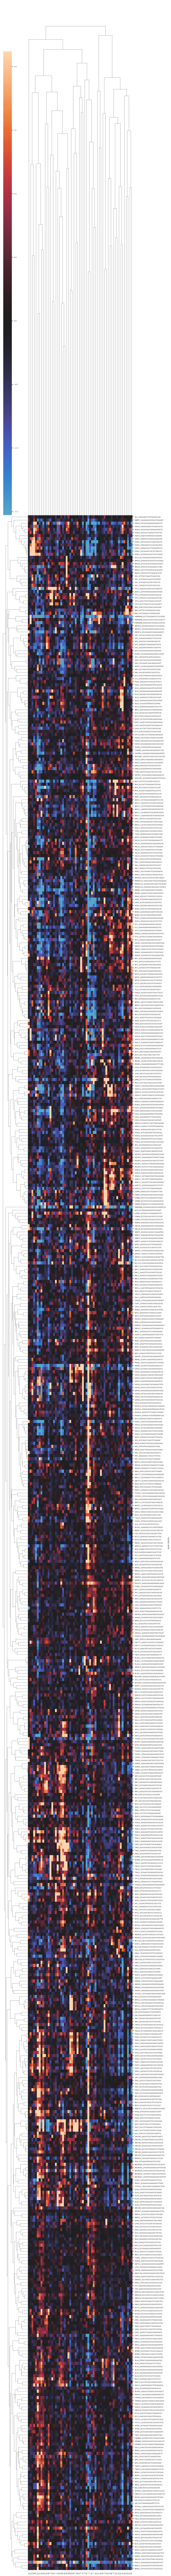

In [118]:
sns.clustermap(codes, robust=True, method='average', metric='correlation', center=0, figsize=[10,150])

In [117]:
expr['CNN1'].sort_values().tail(20)

guide_identity
TBX21_GCCTAGTATTAGCCACGAGA     1.156655
HNF1B_GCTGGATGCAAATGATGGTG     1.170741
PAX3_GCCTCGGCACCACCAGAGAT      1.176549
FOXC2_GAGAGGAGTCGGCGCCAATC     1.206546
HES7_GGCACGAGGCTCCCGGAAAG      1.220225
HAND1_GCGGGCTGAGCGTAAAACCT     1.231163
PRDM1_GGGGCTCGGCCAGGTGGTGT     1.239077
SALL3_GAGCGGCCCGGGCGAGACAA     1.242049
ZEB2_GTTCTCTCTGGGAAAGGATC      1.432888
HELZ2_GGGGAAGCGCCAGCGAGCAG     1.447193
ZNF296_GTTGAGTTAGGCCGCCGTCA    1.463897
GLIS3_GGTCGAGGAACTCCAGAACA     1.510007
HAND1_GGCGGGCTGAGCGTAAAACC     1.567699
GLIS3_GGTGTGTGAATGCGTCAAGA     2.250471
GLIS3_GCAAGAGGGAGACACAAGCT     2.495254
FOXC2_GGAGGAGCGCAGGAATCCGT     2.717462
EOMES_GGTCGGCAGGTGGGTAGCCC     2.952923
GLI1_GGATTGAGGAAAATATTGCG      3.510314
TP73_GAGCGCGGGCCACCGAGTCG      4.072263
CASZ1_GTGGGTGGGAAGGATCCGGG     4.270163
Name: CNN1, dtype: float64

In [110]:
codes[codes.index.str.contains('ZNF296')][35]

guide_identity
ZNF296_GACACTGCCTAGATTGAGTT    2.795918
ZNF296_GCCTGCTGGGGCCCTGACGG    2.156117
ZNF296_GCGGCGGCCTAACTCAATCT    1.433790
ZNF296_GGGACCGAGCCGCCCTGCTG    1.793425
ZNF296_GGTCACTAAGCCAAACGCAC    1.086076
ZNF296_GTTGAGTTAGGCCGCCGTCA    3.694882
Name: 35, dtype: float32

In [108]:
result.loc[35].sort_values().tail(50)

MYH9        0.017919
MRVI1       0.017928
PPIA        0.018358
CDC42EP3    0.018595
EFNB2       0.018691
JAG1        0.018842
SORT1       0.019606
SEPTIN7     0.019653
CFL2        0.020264
LBH         0.020430
HSPA2       0.020463
RBPMS       0.020820
MAP1A       0.023147
PAWR        0.023577
MYL12A      0.025493
VGLL3       0.031099
UCP2        0.031965
RHEB        0.032518
CNN2        0.035600
ZNF281      0.036411
HSD17B6     0.037001
VCL         0.037190
PDLIM7      0.039706
FLNA        0.040207
FHL1        0.043422
CTPS1       0.046274
KCTD20      0.052146
KCNK6       0.054601
CALD1       0.057517
GBP1        0.059866
WFDC1       0.062882
HACD1       0.074852
GLIPR1      0.081403
INHBA       0.081817
FERMT2      0.085977
ACTN1       0.086991
CSRP1       0.098431
MYLK        0.099033
SYNPO2      0.103713
MYL6        0.110103
ACTB        0.127971
NEXN        0.147159
LMOD1       0.183228
HSPB1       0.195818
CNN1        0.261628
TPM1        0.271997
MYL9        0.327388
TPM2        0

In [74]:
result['TGFB2'].sort_values().tail(5)

38    0.001685
35    0.001810
48    0.027561
44    0.142316
39    0.174953
Name: TGFB2, dtype: float32

In [73]:
result.loc[39].sort_values().tail(50)

CTNNAL1     0.026232
TOMM7       0.026690
RAB32       0.027204
ATP5PF      0.027400
NF2         0.027716
PRMT5       0.027744
ARHGAP29    0.027773
COL8A1      0.028011
SEMA3D      0.028476
FBLN1       0.029772
ADI1        0.030141
MCL1        0.031334
ARRDC4      0.031592
RPS27A      0.032817
ZNF106      0.033254
FLNB        0.036131
GREM1       0.036612
MRPS24      0.037741
MRPL33      0.037935
RNASEH1     0.038933
EDN1        0.041154
BCL7B       0.041207
CCBE1       0.041801
CCDC107     0.042378
MGARP       0.044089
SELENOM     0.045094
DAB2        0.046098
NUDT16      0.049776
DSE         0.050077
ABCE1       0.055000
STC2        0.057803
TFRC        0.058456
UFD1        0.061140
FAM98A      0.061604
SLC25A4     0.064049
CPQ         0.064700
NGF         0.064811
GALNT5      0.080105
H2AFJ       0.086549
YBX3        0.092138
TINAGL1     0.102826
ATP8B1      0.105340
PLAAT3      0.116574
TGFBR1      0.117299
TES         0.165419
BTG1        0.174468
TGFB2       0.174953
HTRA1       0

In [69]:
codes[codes.index.str.contains('HES7')].mean().sort_values()

42   -2.833461
53   -2.674452
49   -2.382079
5    -1.589433
33   -1.330810
54   -1.221495
50   -0.988186
10   -0.728595
0    -0.699678
46   -0.655497
51   -0.556406
14   -0.458562
21   -0.383316
52   -0.366902
22   -0.276819
11   -0.259296
6    -0.253309
18   -0.252327
20   -0.243297
27   -0.209689
41   -0.082571
12   -0.079273
26   -0.049343
47   -0.041809
8    -0.033219
38   -0.027454
23   -0.019275
32    0.095781
43    0.126838
37    0.137117
15    0.151012
16    0.159755
7     0.161882
1     0.307266
30    0.309428
19    0.344253
45    0.349683
25    0.387151
17    0.530204
40    0.553442
4     0.594816
55    0.622070
29    0.929690
34    1.015287
24    1.089089
36    1.156828
13    1.449800
9     1.722688
35    1.881700
28    2.238684
56    2.921211
44    3.455212
31    4.392602
2     4.640994
48    5.296783
57    5.565602
39    6.392524
3     6.509339
dtype: float32

In [280]:
sparse_pca = NonNegativeSparsePCA(n_components=result.shape[0],  # number of sparse atoms to extract
                   alpha=1,  # Sparsity-controlling parameter
                   random_state=None,
                   n_jobs=1, verbose=1, method='cd', max_iter=1000)

In [281]:
sparse_pca.fit(expr)

[dict_learning] ......................................................................................................................................................................


NonNegativeSparsePCA(method='cd', n_components=58, n_jobs=1, verbose=1)

In [282]:
bulk_result = pd.DataFrame(sparse_pca.components_, columns=expr.columns)

In [283]:
codes = pd.DataFrame(sparse_pca.transform(expr), index=expr.index)

In [287]:
codes[codes.index.str.contains('HES7')].mean().sort_values()

48   -3.701636
38   -3.186970
12   -2.612684
29   -1.817626
47   -1.566170
27   -1.493854
17   -1.296497
40   -1.252243
53   -1.010988
49   -0.840490
39   -0.784501
24   -0.766653
15   -0.694824
43   -0.651163
45   -0.594215
8    -0.561760
56   -0.541430
16   -0.528926
2    -0.462194
37   -0.424920
3    -0.348966
22   -0.264534
55   -0.261345
11   -0.237718
57   -0.235374
9    -0.147678
30   -0.133943
41   -0.097335
18   -0.074722
36    0.015922
13    0.072215
10    0.101063
46    0.131041
32    0.144031
31    0.186566
14    0.199258
25    0.262206
20    0.278015
6     0.322413
23    0.468379
51    0.559780
0     0.829886
26    0.853410
54    0.917763
42    0.981611
35    1.104539
44    1.180726
19    1.585580
50    1.802650
4     2.184692
21    2.270448
33    2.586325
34    4.267609
52    4.540072
5     4.936190
28    5.539004
1     6.289637
7     8.859365
dtype: float64

In [306]:
for gene in bulk_result.loc[7].sort_values().tail(25).index:
    print(gene)

ADAMTS5
ARID5B
YBX3
WNT5A
CCN2
PALLD
RAB32
MRPS24
HTRA1
CTNNAL1
ATP8B1
COL8A1
PLAAT3
TGFBR1
BTG1
FTH1
UGCG
TGFB2
STC2
TES
IGFBP5
AKAP12
ARHGAP29
NTN4
KRT17


In [307]:
bulk_result.loc[7].sort_values().tail(25)

ADAMTS5     0.080901
ARID5B      0.083465
YBX3        0.084413
WNT5A       0.085170
CCN2        0.085517
PALLD       0.087644
RAB32       0.089411
MRPS24      0.093964
HTRA1       0.101699
CTNNAL1     0.107534
ATP8B1      0.112443
COL8A1      0.117505
PLAAT3      0.122948
TGFBR1      0.126460
BTG1        0.134331
FTH1        0.160793
UGCG        0.166663
TGFB2       0.168242
STC2        0.168644
TES         0.207874
IGFBP5      0.243096
AKAP12      0.276850
ARHGAP29    0.308779
NTN4        0.378459
KRT17       0.414840
Name: 7, dtype: float64

In [300]:
codes[7].sort_values().tail(20)

guide_identity
ZBTB7A_GTCGGAGGCCAGAACAGGCT     1.609614
FOXC2_GGAGGAGTCGGCGCCAATCG      1.653490
FOXI3_GCCGGCCTCCCAGACGCTCC      1.679981
TP73_GTGGACGCGGCCAGCTGGAG       1.752017
FOXL2_GAGGCCGGTCCAGGCTGTGC      1.759657
FOXC2_GGAGAGGAGTCGGCGCCAAT      1.880934
TOPORS_GGGGGGCGAGGGGAAATATC     1.955018
FOXI3_GCCCGGGCCCGGGAGCGTCT      1.985733
FOXC2_GAGAGGAGTCGGCGCCAATC      2.052496
FOXL2_GGGCCGGTCCAGGCTGTGCG      2.198361
POU4F2_GGGAAACGCCGGCTCCTGTT     2.229485
FOXL2_GCAGCCCGCAGAGCGAGTAC      2.377837
CEBPA_GGCAGCCTCGGGATACTCCT      2.534203
TP73_GTCGGGCACAGAGTCGGCAC       2.818778
FOXL2_GGCTGGCCGCCCCGCTATAG      3.117788
TFAP2A_GAGGAGGAGGGCGAGGAGAA     3.995318
HES7_GATTCTGCCCCTCTAGGACC       5.170453
HES7_GCCCTCTAGGACCCGGCACG       5.465062
HES7_GCCTCGTGCCGGGTCCTAGA       8.057485
HES7_GGCACGAGGCTCCCGGAAAG      16.744459
Name: 7, dtype: float64

In [279]:
result.shape

(58, 2473)

In [235]:
result['THY1'].sort_values()

0     0.000000
29    0.000000
30    0.000000
72    0.000000
32    0.000000
        ...   
85    0.011290
25    0.021544
84    0.058565
59    0.076482
58    0.086487
Name: THY1, Length: 91, dtype: float32

In [258]:
result.loc[58].sort_values().tail(20)

HSP90AA1     0.024381
TNFRSF12A    0.026008
HOMER3       0.026677
FADS3        0.029115
S100A11      0.032781
SUB1         0.033118
TMSB10       0.036107
AHNAK        0.038075
ANXA5        0.044132
GSTO1        0.048610
ARPC1B       0.051223
SH3BGRL3     0.051345
LDHA         0.054461
CCBE1        0.058720
CLIC1        0.070511
ITGB1        0.080983
THY1         0.086487
LMNA         0.117336
LGALS1       0.146155
VIM          0.957669
Name: 58, dtype: float32

In [241]:
mean_pop.genes.index.name = 'gene_id'

In [257]:
mean_pop.where(cells='masked_active', genes=['LGALS1']).iloc[:,0].sort_values().head(20)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


guide_identity
HNRNPAB_GCTTCGGGAGCCCTCCGTAG    -3.366509
TP73_GAGCGCGGGCCACCGAGTCG       -2.352850
HNRNPAB_GCGGGACGGCGCCGGGTCCA    -1.764857
OVOL1_GGGTTCGACAGGTAACAAAT      -1.764092
PPARGC1A_GTAGAGCAGCAAGCTGCACA   -1.667302
PRDM1_GCAATCTGGGGGAAAGCCCT      -1.406567
TGIF1_GAAGACTGGACCGAGCGCGG      -1.261052
HOXA13_GACGGCGTATGCAAAGCGGG     -1.247757
BCL11B_GACCCAGAGAGTCGGAGCAC     -1.225023
PRDM1_GGCTAAGGAAATCTTAAGCA      -1.213005
KLF5_GAAGTTGTGTACAAACTGCG       -1.206544
MYC_GTCCCCTCCTGCCTCGAGAA        -1.163036
IRF4_GTCCAACCCCCGGCCCCCAC       -1.131695
CDX2_GGGGAAGACCCGCCACAGGC       -1.073825
TP73_GTCGGGCACAGAGTCGGCAC       -1.038347
TFCP2L1_GCGCGGGAGTCAGCCAGGTG    -1.021498
HES7_GGCACGAGGCTCCCGGAAAG       -1.016216
HOXA13_GCGCGGGTCTGGGCCCCACT     -0.982635
FOXD3_GGGGATGCTGGCGCACAGTG      -0.969402
SP3_GTGCCCGGGCGCAGTCGGCG        -0.967491
Name: LGALS1, dtype: float64

In [151]:
(result.reindex(senescence_genes, axis=1).dropna(axis=1)>0.01).mean(axis=1).sort_values()

0     0.000000
45    0.000000
36    0.000000
56    0.000000
27    0.000000
18    0.000000
11    0.000000
9     0.000000
28    0.000000
8     0.000000
10    0.027027
6     0.027027
29    0.027027
13    0.027027
3     0.027027
50    0.027027
16    0.027027
48    0.027027
5     0.027027
19    0.027027
4     0.027027
22    0.027027
40    0.027027
35    0.027027
33    0.054054
1     0.054054
39    0.054054
44    0.054054
52    0.054054
54    0.054054
37    0.054054
32    0.054054
57    0.054054
26    0.054054
12    0.054054
25    0.054054
23    0.054054
30    0.081081
55    0.081081
15    0.081081
17    0.081081
47    0.081081
46    0.081081
31    0.081081
20    0.081081
24    0.081081
2     0.081081
34    0.081081
7     0.081081
51    0.108108
14    0.108108
53    0.108108
41    0.135135
42    0.162162
21    0.162162
38    0.189189
49    0.216216
43    0.270270
dtype: float64

In [90]:
result.loc[43].sort_values().tail(20)

CCN2        0.095878
THBS1       0.100115
CTHRC1      0.102593
ARHGAP29    0.115644
RFLNB       0.115816
PRDX6       0.132852
PSG4        0.134694
SLC8A1      0.138034
USP53       0.144581
SLC7A5      0.147138
DKK1        0.148356
CDH2        0.152374
STMN2       0.175473
PRSS12      0.187766
ELN         0.216688
TLE4        0.233567
KRT19       0.284152
KRT34       0.288172
ALDH1A1     0.372236
PSG5        0.383233
Name: 43, dtype: float32

In [159]:
codes[[43,49]].mean(axis=1).sort_values().tail(20)

guide_identity
FOSB_GGACAGTGCGGGACTCGATT      1.216442
GSX2_GGCGGCGGGGAAGAACTCGG      1.240446
MXI1_GGAGCCTGTCGCCATCGGAC      1.270793
CEBPA_GGCAGCCTCGGGATACTCCT     1.359950
FOXD2_GCGGCCGCGCTCACCTTCCA     1.365140
HAND1_GGGGTGGCAGCAACAGTCCA     1.377423
NFATC1_GGGGGCGTGATGTCACGGCA    1.388022
STAT2_GTGGGAAGGGCTTGACTGAA     1.411371
TSHZ1_GTTACCCGGTATCAGCCAGT     1.451938
HMX3_GCGGCACCGAGGGATCGAGG      1.453977
EP300_GCTCCCCCGGCGTCACCCTG     1.563845
TBX20_GCCACGCGGGCGCCGCACCC     1.603695
TOPORS_GGGGGGCGAGGGGAAATATC    1.605594
TSHZ1_GGTAATTGTCAGGGTGACGT     1.719556
NR2F2_GGTCCGGCCAATGACGGCGA     1.802114
NFATC1_GCATCACGCCCCTGCTGCCC    1.833674
TP73_GTCGGGCACAGAGTCGGCAC      1.952198
BSX_GGCCGGGAGAGCCAATGACG       2.107218
STAT2_GCTGAATGGCAGCCAGTGTC     2.132751
JUN_GCCCAGAGAAGAATCTTCTA       2.298655
dtype: float32

In [158]:
codes[[43,49]].loc['TP73_GTCGGGCACAGAGTCGGCAC']

43    2.817309
49    1.087086
Name: TP73_GTCGGGCACAGAGTCGGCAC, dtype: float32

In [136]:
codes[43].sort_values().tail(20)

guide_identity
IRF1_GCAGGCTGTTGTAGAGCTAG      2.039763
THRA_GGCTCGCGGCTGCTCCCTGC      2.052129
SOX12_GGGCCCGGCCCCCGCGAACT     2.099197
FOXJ1_GTCGAAGAGAGTTGCCGCCA     2.280463
ZBTB7A_GGGGTCCTCCCTTGTCTTAA    2.330721
STAT2_GCTGAATGGCAGCCAGTGTC     2.418559
STAT2_GTGGGAAGGGCTTGACTGAA     2.448993
FOXP4_GCGAGAGAGCAAGCGGCGGA     2.492429
NFATC1_GGGGGCGTGATGTCACGGCA    2.501751
SOX12_GAACTGGGGAGCGAGGAGCT     2.543427
NR2F2_GGTCCGGCCAATGACGGCGA     2.595476
SOX18_GGCCTCAGCGGAATCCCGCC     2.634783
TOPORS_GGGGGGCGAGGGGAAATATC    2.733889
SOX18_GTGCGCGGGGGAGGCCTCAG     2.755761
TP73_GTCGGGCACAGAGTCGGCAC      2.817309
SOX18_GGAGAAGAAAGGGAGCCCCC     2.932427
TSHZ1_GTTACCCGGTATCAGCCAGT     2.943647
NFATC1_GCATCACGCCCCTGCTGCCC    2.978663
SMAD1_GGAGAGGATCCCTGGTCGCG     2.996649
TSHZ1_GGTAATTGTCAGGGTGACGT     3.575256
Name: 43, dtype: float32

In [139]:
codes[49].sort_values().tail(20)

guide_identity
ZFP36L2_GCGGCGTTGCCTGGAGACCC    1.805193
STAT2_GCTGAATGGCAGCCAGTGTC      1.846942
HAND1_GCGGGCTGAGCGTAAAACCT      1.866249
MNX1_GGCGGGCGGGGACACCAACG       1.966437
BID_GAACAGTCGCGTAAGGGGTA        2.009125
TBX20_GCCACGCGGGCGCCGCACCC      2.070706
MXI1_GGACCGGTCAAAATAAAAGG       2.106660
TP73_GAGCGCGGGCCACCGAGTCG       2.165315
JUN_GGAAAGAAGGGCCCGACTGT        2.179927
IRF1_GGCGAAGGGGAAGTACAGGG       2.224210
FOXD2_GCGGCCGCGCTCACCTTCCA      2.256317
BSX_GCCGCGGTGCTGAACACCAC        2.259723
HHEX_GCACCAGGGCGCCAGTTCCC       2.264586
GLIS3_GGGCTCGCGGGTCACTAGGC      2.373408
MNX1_GCAGCGCCGCGCAACAGCCC       2.381237
EP300_GGGCAGGAGGAGGGTTCGGA      2.732989
HMX3_GCGGCACCGAGGGATCGAGG       2.781377
EP300_GCTCCCCCGGCGTCACCCTG      2.927951
BSX_GGCCGGGAGAGCCAATGACG        2.975041
JUN_GCCCAGAGAAGAATCTTCTA        3.162355
Name: 49, dtype: float32

In [102]:
codes[13].sort_values().tail(20)

guide_identity
NEUROD1_GACAGCCTGGACGCGTGCGC    2.734839
FOSB_GGACAGTGCGGGACTCGATT       2.772876
PAX3_GCGGGCCAACCTTCTCTCCT       2.834580
JUN_GCCCAGAGAAGAATCTTCTA        2.913555
ZNF618_GCGGGTGTGCCGCGGCACTG     2.998813
NEUROD1_GGGGTGAGGGGAGCGGTTGT    3.015350
OSR1_GGGGGAGGAATCCTGAGGCA       3.029132
FOSB_GACCTCTTGCTGGACAGTGC       3.034375
GLIS3_GCAAGAGGGAGACACAAGCT      3.157672
EP300_GGGCAGGAGGAGGGTTCGGA      3.174396
HES7_GATTCTGCCCCTCTAGGACC       3.182333
SOX15_GAGGGGAGGCAATCAGCAAC      3.485849
HIVEP1_GCGGAGCCACGGCATGATCG     3.610587
FOXF1_GGCTGCACCTCTGCCGTCAT      3.941134
IRF1_GGCGAAGGGGAAGTACAGGG       3.979051
PAX5_GTCGGTCTGCCCCTTCCCGT       4.120637
TBX20_GCTGGGGTACCGAACAGCCG      4.134805
KLF5_GAAGTTGTGTACAAACTGCG       5.774620
NKX3-1_GCTGGGGAAGGAATCCCCTA     6.657274
FOXC2_GGAGGAGCGCAGGAATCCGT      9.304249
Name: 13, dtype: float32

In [147]:
result.loc[50].sort_values()

FUCA2      0.000000
PAPPA      0.000000
SLC35E1    0.000000
MACF1      0.000000
MXRA7      0.000000
             ...   
CLIC1      0.191620
S100A11    0.246601
TMSB10     0.319120
LGALS1     0.417591
VIM        0.538700
Name: 50, Length: 2473, dtype: float32

In [144]:
codes[codes.index.str.contains('TSHZ1')].mean().sort_values()

50   -1.464284
1    -1.031455
53   -1.011227
0    -0.754664
22   -0.752255
44   -0.730246
25   -0.682308
14   -0.656836
13   -0.651815
47   -0.586603
32   -0.574327
4    -0.556302
56   -0.523681
57   -0.511656
36   -0.508651
21   -0.500778
24   -0.454818
6    -0.428315
42   -0.426985
27   -0.394998
30   -0.358343
41   -0.340758
35   -0.332049
52   -0.330804
18   -0.313883
29   -0.250985
54   -0.243754
12   -0.242837
34   -0.233864
17   -0.204283
55   -0.195684
9    -0.170953
39   -0.167405
40   -0.150277
46   -0.142597
15   -0.091348
23   -0.090221
49   -0.087958
28   -0.061070
7    -0.034657
26   -0.002666
37    0.019518
19    0.024771
48    0.046931
8     0.058683
2     0.062655
20    0.084614
45    0.128907
33    0.183914
38    0.200626
51    0.241852
31    0.419804
10    0.487722
16    0.853543
11    1.268701
5     1.467812
3     2.420634
43    3.259452
dtype: float32

In [141]:
codes[codes.index.str.contains('HNRNPA')].mean().sort_values()

56    -5.598814
50    -2.726993
51    -2.188812
3     -2.106939
53    -1.768102
55    -1.680592
13    -1.544608
47    -1.423180
2     -1.421027
36    -1.357874
14    -1.357493
4     -1.302466
25    -1.291540
43    -1.264762
23    -1.262493
35    -1.225133
54    -1.199060
9     -1.178293
46    -0.931520
21    -0.925751
18    -0.904065
32    -0.796144
57    -0.720947
48    -0.638445
22    -0.612415
30    -0.611069
49    -0.607695
45    -0.578686
6     -0.544540
8     -0.521442
27    -0.489740
0     -0.468719
11    -0.425011
1     -0.381644
38    -0.362645
39    -0.230266
40    -0.211096
37    -0.207004
20    -0.180272
44    -0.064620
19    -0.051511
33    -0.048679
29     0.012178
16     0.129554
10     0.165284
31     0.186325
41     0.318652
24     0.326623
34     0.346666
12     0.352426
7      0.452206
42     0.704406
5      0.904350
28     0.971947
26     1.795392
15     2.047603
52     8.988011
17    11.008107
dtype: float32

In [75]:
senescence_genes = [
    "ACVR1B", "ANG", "ANGPT1", "ANGPTL4", "AREG", "AXL", "BEX3", "BMP2", "BMP6", "C3", 
    "CCL1", "CCL13", "CCL16", "CCL2", "CCL20", "CCL24", "CCL26", "CCL3", "CCL3L1", "CCL4", 
    "CCL5", "CCL7", "CCL8", "CD55", "CD9", "CSF1", "CSF2", "CSF2RB", "CST4", "CTNNB1", 
    "CTSB", "CXCL1", "CXCL10", "CXCL12", "CXCL16", "CXCL2", "CXCL3", "CXCL8", "CXCR2", "DKK1", 
    "EDN1", "EGF", "EGFR", "EREG", "ESM1", "ETS2", "FAS", "FGF1", "FGF2", "FGF7", 
    "GDF15", "GEM", "GMFG", "HGF", "HMGB1", "ICAM1", "ICAM3", "IGF1", "IGFBP1", "IGFBP2", 
    "IGFBP3", "IGFBP4", "IGFBP5", "IGFBP6", "IGFBP7", "IL10", "IL13", "IL15", "IL18", "IL1A", 
    "IL1B", "IL2", "IL32", "IL6", "IL6ST", "IL7", "INHA", "IQGAP2", "ITGA2", "ITPKA", 
    "JUN", "KITLG", "LCP1", "MIF", "MMP1", "MMP10", "MMP12", "MMP13", "MMP14", "MMP2", 
    "MMP3", "MMP9", "NAP1L4", "NRG1", "PAPPA", "PECAM1", "PGF", "PIGF", "PLAT", "PLAU", 
    "PLAUR", "PTBP1", "PTGER2", "PTGES", "RPS6KA5", "SCAMP4", "SELPLG", "SEMA3F", "SERPINB4", "SERPINE1", 
    "SERPINE2", "SPP1", "SPX", "TIMP2", "TNF", "TNFRSF10C", "TNFRSF11B", "TNFRSF1A", "TNFRSF1B", "TUBGCP2", 
    "VEGFA", "VEGFC", "VGF", "WNT16", "WNT2"
]

In [192]:
fibroblast_low_UMI_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240310_fibroblast_final_low_UMI_count_regressions_coef_mean_pop.hdf',
stored_matrix_ids=['p', 'adj_p', 'naive_mean_profile', 'count_profile'])

Loading matrix...
Loading metadata...
Done in 58.53152346611023s.
Done.


In [197]:
fibroblast_low_UMI_mean_pop.where(genes=['DPT']).iloc[:,0].sort_values()

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


guide_identity
HLTF_GTGCCATTCAAAGACGGCGG      -0.110521
THAP2_GTAGATCCGCTCCCTCTTGG     -0.070434
ZNF624_GCTCAGGCGCTGAGGATTCT    -0.069133
MIDEAS_GGAAGGCGTCCTTAAACCTC    -0.058570
NFIC_GGGCACTAGACCAGGACCCC      -0.048529
                                  ...   
NR1D1_GGCAGGTACCATGTGATCCC      0.316261
RUNX1T1_GCAGAAATGTGGAGGATGAC    0.330534
MEF2C_GGTGGCTCTCAGCGGCCGGT      0.451494
ZBTB14_GAGCGAGCGCGGGGAACCCA     0.661642
SNAI2_GCCCGCCTGGCTTCCAGATG      3.856300
Name: DPT, Length: 10917, dtype: float64

In [211]:
fibroblast_low_UMI_mean_pop.where(genes=['DPT'], normalized=True, normalized_name='count_profile').iloc[:,0].sort_values()

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


RCOR3_GCGGAGCGGAGTGATACCGG       0
VAX2_GAAGACTCCCAGCTGCGCCG        0
VAX2_GAGGAGGAGGAGTCGAGCGG        0
VAX2_GCCGCCCAATCAGCAGGGAG        0
VAX2_GGACTCCCGCCCAATCAGCA        0
                              ... 
NR1D2_GCGAGGGCGGCTGACGGGGA       6
ZFAT_GACCCCCTCGGAGTGCTGGT        6
ZBTB14_GAGCGAGCGCGGGGAACCCA     22
SNAI2_GCCCGCCTGGCTTCCAGATG      29
control                        134
Name: DPT, Length: 10917, dtype: int64

In [213]:
(fibroblast_low_UMI_mean_pop.where(genes=['LRRC15'])*(fibroblast_low_UMI_mean_pop.where(genes=['LRRC15'], normalized=True, normalized_name='adj_p')<0.001)*(fibroblast_low_UMI_mean_pop.where(genes=['LRRC15'], normalized=True, normalized_name='count_profile')>=5)).iloc[:,0].sort_values().tail(20)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **

guide_identity
MAPK8IP1_GCAGGGGCCGCCGGAGACTG    0.000000
MAPK8IP1_GCCGCGGAGAGCGCCATCTC   -0.000000
MAX_GTCCCTCTAACAGACGGCCC        -0.000000
MAPK8IP1_GCGGAGAGCGCCATCTCCGG   -0.000000
MAPK8IP1_GGGAGGGCGCAAGGAGTCCG   -0.000000
MAPK8IP1_GGGGAGGTGCTGGCCGTCAG    0.000000
MAX_GACCCGGGCCGTCTGTTAGA        -0.000000
MAX_GCCCGGAAGAAACCGCATCC         0.000000
MAX_GCGCCAGCCCGGCTTGTTGA         0.000000
MAP3K7_GGCCGTAAACTCCGGGGTAG     -0.000000
control                          0.003865
TFAP4_GCGGGGACCGGCTGCAACCG       0.028702
LHX3_GAGGGAGGCGCGCCCGACAC        0.041763
ZNF677_GGGACTGCCGGACCTCTCCT      0.071005
THRA_GGAGCAGCCGCGAGCCGGCC        0.083406
ZBTB20_GGGGAGAGATAGAGGGTTCG      0.084555
CRTC2_GCAGCAGGGCTGCTGGGAAG       0.101456
ZBTB34_GTCCCGGAGTCGGGACTCCG      0.151101
EOMES_GGCAGTAGCGGCCCGCGAGT       0.161293
NCOA1_GCCGCGGAGGCCCTAGGGGG       0.540497
Name: LRRC15, dtype: float64

In [217]:
mean_pop.cells.query('target_gene=="ZBTB34"')

,protospacer,target_gene,target_expr,active,cluster,cluster_name,cluster_description,gene_driven,sequence_driven,sequence_suffix,...,cell_count,target_gene_id,masked_active,masked_cluster,masked_cluster_name,masked_cluster_description,masked_cluster_size,masked_cluster_num_genes,stricter_masked_cluster,stricter_masked_cluster_description
guide_identity,,,,,,,,,,,,,,,,,,,,,
ZBTB34_GAGGCTCTGGGACGACAACC,GAGGCTCTGGGACGACAACC,ZBTB34,NaN,False,749.0,NaN,749: neither (4),False,False,,...,68.0,NaN,False,178.0,NaN,178: neither (8),8.0,8.0,268.0,268: SEQUENCE-driven (CAACC) (2)
ZBTB34_GAGGGGCTCCCGGAATCGAA,GAGGGGCTCCCGGAATCGAA,ZBTB34,NaN,False,27.0,NaN,27: neither (12),False,False,,...,74.0,NaN,False,2267.0,NaN,2267: neither (3),3.0,3.0,3178.0,3178: neither (3)
ZBTB34_GCGCGGCGGACCTCTAGCCA,GCGCGGCGGACCTCTAGCCA,ZBTB34,NaN,False,578.0,NaN,578: neither (7),False,False,,...,83.0,NaN,False,2040.0,NaN,2040: neither (7),7.0,7.0,2933.0,2933: neither (7)
ZBTB34_GGCTCCCGGAATCGAACGGG,GGCTCCCGGAATCGAACGGG,ZBTB34,NaN,False,1441.0,NaN,1441: SEQUENCE-driven (CCGGG) (4),False,True,CCGGG,...,45.0,NaN,False,1195.0,NaN,1195: SEQUENCE-driven (CCGGG) (4),4.0,4.0,1681.0,1681: SEQUENCE-driven (CCGGG) (4)
ZBTB34_GGGAGAAGGGCGGTGCAGTG,GGGAGAAGGGCGGTGCAGTG,ZBTB34,NaN,False,1213.0,NaN,1213: neither (5),False,False,,...,79.0,NaN,False,1338.0,NaN,1338: neither (4),4.0,4.0,1927.0,1927: neither (4)
ZBTB34_GTCCCGGAGTCGGGACTCCG,GTCCCGGAGTCGGGACTCCG,ZBTB34,NaN,False,474.0,NaN,474: neither (10),False,False,,...,60.0,NaN,False,1969.0,NaN,1969: neither (10),10.0,9.0,2842.0,2842: neither (10)


In [327]:
mean_pop.where(cells='masked_active')

gene_name,ENSG00000000419,ENSG00000001036,ENSG00000001461,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002834,...,ENSG00000277972,ENSG00000278053,ENSG00000278311,ENSG00000278845,ENSG00000280789,ENSG00000281649,ENSG00000282057,ENSG00000283103,ENSG00000284194,ENSG00000285437
guide_identity,,,,,,,,,,,,,,,,,,,,,
AFF1_GGAACCCGGTACCGCAGCTC,-0.383454,-0.198111,0.130386,-0.116920,-0.194140,0.200941,0.098740,-0.089012,0.264866,-0.010186,...,-0.132012,-0.007117,-0.066108,-0.093998,0.010748,-0.004688,0.019119,-0.126545,0.029988,0.065362
AFF1_GGGCGCCACCCAAGCGGCAA,0.024064,-0.094530,0.067372,0.202128,0.133753,-0.116156,0.096009,-0.010778,0.378749,0.018844,...,0.087336,0.150039,0.161370,0.150234,0.004403,0.097843,-0.184472,-0.295614,-0.040748,-0.055551
AFF1_GTTGGGTGGCGCCAGCTAGA,0.152990,0.384469,-0.277394,0.091128,0.136092,-0.457715,-0.074810,0.193602,0.473469,-0.190371,...,0.096045,-0.026223,-0.142561,0.089372,-0.131976,0.292587,-0.023837,0.173662,0.086365,0.024043
ALX4_GAGAGAGAGGCCGGCGTGGA,-0.181635,-0.019436,-0.261196,-0.063670,-0.131656,-0.022310,0.313222,0.079502,0.446053,0.135567,...,0.160202,0.252682,0.086196,-0.087524,0.087060,-0.268149,0.111680,-0.197010,0.136031,0.178665
ALX4_GCGGGCGGGGACGCGAGCGA,-0.081921,0.256539,-0.147036,-0.371980,-0.121378,0.045541,0.138690,-0.119124,0.267064,-0.008469,...,0.207133,0.032278,-0.255813,-0.063131,-0.227022,0.021617,0.171679,-0.057908,-0.101303,-0.160136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF777_GTGTGAGAGGCGCAGGGGAT,-0.607563,-0.189170,-0.348679,-0.343365,-0.100329,-0.036302,0.047512,-0.137453,0.141271,0.322612,...,0.015009,0.126069,-0.477147,-0.239848,0.116501,0.023215,0.406192,-0.170143,0.215882,-0.049065
ZNF827_GAGCCCCTAACACTAATGTC,-0.116921,0.122692,0.099363,0.078711,-0.387438,-0.314231,-0.135397,0.137121,-0.437763,-0.174468,...,-0.404786,-0.231594,-0.273763,0.359168,-0.266496,0.100351,0.130179,-0.051756,-0.165678,-0.081506
ZNF827_GCACAAGAGGCACAGACTGA,0.351807,-0.594196,-0.246334,0.248182,-0.228168,0.530248,0.347107,-0.367791,-0.322316,-0.020466,...,-0.088063,0.219465,0.095684,-0.415754,-0.037393,-0.213783,-0.117210,0.177264,-0.469294,-0.331486


In [386]:
masked_active = mean_pop.cells.query('masked_active').index

In [414]:
mean_pop.where(cells='masked_active', genes=senescence_genes).quantile(0.1, axis=1).sort_values().head(20)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


guide_identity
HNRNPAB_GCGGGACGGCGCCGGGTCCA   -1.378811
FOXC2_GGAGGAGCGCAGGAATCCGT     -1.246803
TP73_GAGCGCGGGCCACCGAGTCG      -1.132909
PRDM1_GCAATCTGGGGGAAAGCCCT     -1.068311
HNRNPAB_GCTTCGGGAGCCCTCCGTAG   -1.033829
FOXE1_GTCCGCACCCCGATCGACTG     -0.823962
HOXA13_GGGCCCAGACCCGCGCAACC    -0.790317
BBX_GTTCGGGACCTGTAGACAGT       -0.771200
FOXA3_GTCGCCAGGAGACAGACCTC     -0.771070
GATA2_GCCGGCCCGCGGGTCAGTCC     -0.743139
TFAP2E_GTTCCCCAGCGGCTGCCACA    -0.737665
OVOL1_GGGTTCGACAGGTAACAAAT     -0.727350
CASZ1_GTGGGTGGGAAGGATCCGGG     -0.701431
HES7_GGCACGAGGCTCCCGGAAAG      -0.699739
ZBTB7A_GTCGGAGGCCAGAACAGGCT    -0.697976
HOXA13_GCGGCCGCGCACCATTCACC    -0.682906
IRF4_GCTCTCCCCAGTCCAACCCC      -0.682059
NEUROD2_GTGGCATGCGTCTGCACTGG   -0.679440
BSX_GCCGCGGTGCTGAACACCAC       -0.672373
JUNB_GCCTCCTCGAGCGTGGGGAA      -0.671149
Name: 0.1, dtype: float64

In [448]:
from scipy.stats import trim_mean

In [458]:
mean_pop.where(cells='masked_active', genes=senescence_genes).apply(lambda x: trim_mean(x, 0.05), axis=1).sort_values().head(20)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


guide_identity
PRDM1_GCAATCTGGGGGAAAGCCCT     -0.397715
HNRNPAB_GCTTCGGGAGCCCTCCGTAG   -0.334707
FOXC2_GGAGGAGCGCAGGAATCCGT     -0.308625
HNRNPAB_GCGGGACGGCGCCGGGTCCA   -0.249541
NEUROD2_GTGGCATGCGTCTGCACTGG   -0.237645
FOXE1_GTCCGCACCCCGATCGACTG     -0.226762
TFAP2E_GTTCCCCAGCGGCTGCCACA    -0.225568
BCL11B_GGGAGCTCTCGGTCTCTCTA    -0.206544
ZBTB7A_GTCGGAGGCCAGAACAGGCT    -0.200393
IRF4_GCTCTCCCCAGTCCAACCCC      -0.198190
CDX2_GGGGAAGACCCGCCACAGGC      -0.193783
PRDM1_GGCTAAGGAAATCTTAAGCA     -0.188054
OVOL1_GGGTTCGACAGGTAACAAAT     -0.182946
BSX_GGCCGGGAGAGCCAATGACG       -0.180342
BBX_GTTCGGGACCTGTAGACAGT       -0.179650
MYC_GTCCCCTCCTGCCTCGAGAA       -0.177003
BSX_GCCGCGGTGCTGAACACCAC       -0.175760
GFI1_GGCGATGAGTAGCTGAGTTG      -0.169305
IRF4_GTCCAACCCCCGGCCCCCAC      -0.168681
CASZ1_GGTGATTATGGAATTCTCCG     -0.165963
dtype: float64

In [459]:
codes[codes.index.str.contains('HNRNPAB')].mean().sort_values()

52    -5.714090
30    -4.025489
49    -3.488026
1     -2.763842
29    -2.277484
0     -2.106689
46    -2.057204
53    -1.999184
28    -1.702076
10    -1.656406
2     -1.543504
19    -1.506671
45    -1.489586
31    -1.453415
44    -1.331865
15    -1.255692
43    -1.253047
38    -0.911805
55    -0.896726
17    -0.843343
16    -0.733254
57    -0.644609
11    -0.572393
8     -0.520235
23    -0.512529
20    -0.502312
4     -0.495731
36    -0.495055
39    -0.472162
33    -0.467872
40    -0.463466
48    -0.453421
25    -0.442764
9     -0.438811
14    -0.428671
22    -0.422901
13    -0.355845
54    -0.317755
37    -0.305316
51    -0.285135
21     0.157346
24     0.181581
7      0.186144
32     0.289401
35     0.324392
42     0.332870
56     0.333443
34     0.374349
27     0.431295
41     0.464667
26     0.711021
47     0.856813
18     1.530041
50     1.682103
5      2.307967
12     2.399381
3     10.312785
6     11.070639
dtype: float64

In [461]:
(codes[codes.index.str.contains('HNRNPAB')].mean() - codes[codes.index.str.contains('CEBPA')].mean()).sort_values()

52    -5.223495
30    -4.834487
11    -4.388377
42    -3.944880
1     -3.927495
49    -3.398812
29    -3.227374
43    -2.826934
19    -2.312471
45    -2.074814
23    -1.893050
53    -1.711213
46    -1.675818
25    -1.548797
10    -1.504864
28    -1.463494
44    -1.424860
0     -1.353324
41    -1.321981
2     -1.278553
40    -1.246723
15    -1.116070
31    -1.039580
14    -1.005819
7     -0.829011
34    -0.820132
47    -0.751750
17    -0.664965
48    -0.619571
33    -0.578668
37    -0.501444
55    -0.481703
8     -0.475609
13    -0.466227
39    -0.463291
4     -0.454194
57    -0.382547
54    -0.324509
36    -0.321611
27    -0.315002
22    -0.241073
16    -0.238802
9     -0.230247
38    -0.025207
35    -0.020305
32    -0.010626
21     0.159491
24     0.178198
20     0.196865
51     0.284654
56     0.546886
26     0.813042
50     1.743707
12     1.749479
18     2.504526
5      3.482692
3     10.431148
6     10.951195
dtype: float64

In [457]:
codes[codes.index.str.contains('CEBPA')].mean().sort_values()

5    -1.174725
18   -0.974484
38   -0.886598
0    -0.753365
20   -0.699176
51   -0.569789
16   -0.494452
52   -0.490596
55   -0.415023
31   -0.413836
46   -0.381387
53   -0.287971
2    -0.264951
57   -0.262062
28   -0.238583
56   -0.213443
9    -0.208564
22   -0.181828
17   -0.178378
36   -0.173444
10   -0.151542
15   -0.139622
3    -0.118363
26   -0.102021
49   -0.089214
50   -0.061604
8    -0.044626
4    -0.041537
39   -0.008871
21   -0.002145
24    0.003383
54    0.006753
44    0.092994
13    0.110383
33    0.110795
6     0.119444
48    0.166150
37    0.196128
32    0.300027
35    0.344697
14    0.577148
45    0.585228
12    0.649902
27    0.746297
40    0.783257
19    0.805800
30    0.808999
29    0.949890
7     1.015155
25    1.106033
1     1.163653
34    1.194481
23    1.380520
43    1.573888
47    1.608563
41    1.786648
11    3.815983
42    4.277750
dtype: float64

In [463]:
result.loc[18].sort_values().tail(20)

GSTM3      0.020118
NFE2L2     0.022036
ASPH       0.025013
MGST1      0.031215
GCLM       0.032833
PTGR1      0.034124
FTH1       0.036860
SQSTM1     0.044081
AKR1B1     0.065098
G6PD       0.081181
PGD        0.084774
HINT1      0.095628
PRDX1      0.119751
SLC7A11    0.184982
TALDO1     0.198730
TKT        0.210902
FTL        0.230677
TXNRD1     0.232094
TXN        0.276493
NQO1       0.804432
Name: 18, dtype: float32

In [443]:
codes[codes.index.str.startswith('HNRNPAB')].mean().sort_values()

52    -5.714090
30    -4.025489
49    -3.488026
1     -2.763842
29    -2.277484
0     -2.106689
46    -2.057204
53    -1.999184
28    -1.702076
10    -1.656406
2     -1.543504
19    -1.506671
45    -1.489586
31    -1.453415
44    -1.331865
15    -1.255692
43    -1.253047
38    -0.911805
55    -0.896726
17    -0.843343
16    -0.733254
57    -0.644609
11    -0.572393
8     -0.520235
23    -0.512529
20    -0.502312
4     -0.495731
36    -0.495055
39    -0.472162
33    -0.467872
40    -0.463466
48    -0.453421
25    -0.442764
9     -0.438811
14    -0.428671
22    -0.422901
13    -0.355845
54    -0.317755
37    -0.305316
51    -0.285135
21     0.157346
24     0.181581
7      0.186144
32     0.289401
35     0.324392
42     0.332870
56     0.333443
34     0.374349
27     0.431295
41     0.464667
26     0.711021
47     0.856813
18     1.530041
50     1.682103
5      2.307967
12     2.399381
3     10.312785
6     11.070639
dtype: float64

In [434]:
np.intersect1d(result.columns, senescence_genes)

array(['ANGPT1', 'AXL', 'BEX3', 'CCL2', 'CD9', 'CTSB', 'CXCL12', 'DKK1',
       'EDN1', 'EGFR', 'EREG', 'ETS2', 'FGF2', 'GDF15', 'HMGB1', 'IGFBP2',
       'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7', 'IL6ST', 'JUN',
       'KITLG', 'MIF', 'MMP1', 'MMP2', 'MMP3', 'NRG1', 'PAPPA', 'PLAT',
       'PLAUR', 'SERPINE1', 'SERPINE2', 'TIMP2', 'TNFRSF11B', 'VEGFC'],
      dtype=object)

In [432]:
result[np.intersect1d(result.columns, senescence_genes)].median(axis=1).sort_values()

0     0.000000e+00
25    0.000000e+00
26    0.000000e+00
56    0.000000e+00
29    0.000000e+00
31    0.000000e+00
32    0.000000e+00
34    0.000000e+00
36    0.000000e+00
37    0.000000e+00
38    0.000000e+00
41    0.000000e+00
42    0.000000e+00
44    0.000000e+00
47    0.000000e+00
48    0.000000e+00
49    0.000000e+00
52    0.000000e+00
53    0.000000e+00
55    0.000000e+00
24    0.000000e+00
23    0.000000e+00
28    0.000000e+00
5     0.000000e+00
8     0.000000e+00
9     0.000000e+00
22    0.000000e+00
3     0.000000e+00
10    0.000000e+00
11    0.000000e+00
12    0.000000e+00
6     0.000000e+00
13    0.000000e+00
4     0.000000e+00
14    0.000000e+00
15    0.000000e+00
2     0.000000e+00
16    0.000000e+00
17    0.000000e+00
1     0.000000e+00
18    0.000000e+00
19    0.000000e+00
20    0.000000e+00
7     0.000000e+00
51    4.668950e-07
35    5.121677e-07
57    6.202822e-07
33    1.471513e-06
46    1.707859e-06
21    2.189811e-06
43    9.493057e-06
30    2.220003e-05
50    3.3915

In [415]:
senescence_expr = mean_pop.where(cells='masked_active', genes=senescence_genes)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


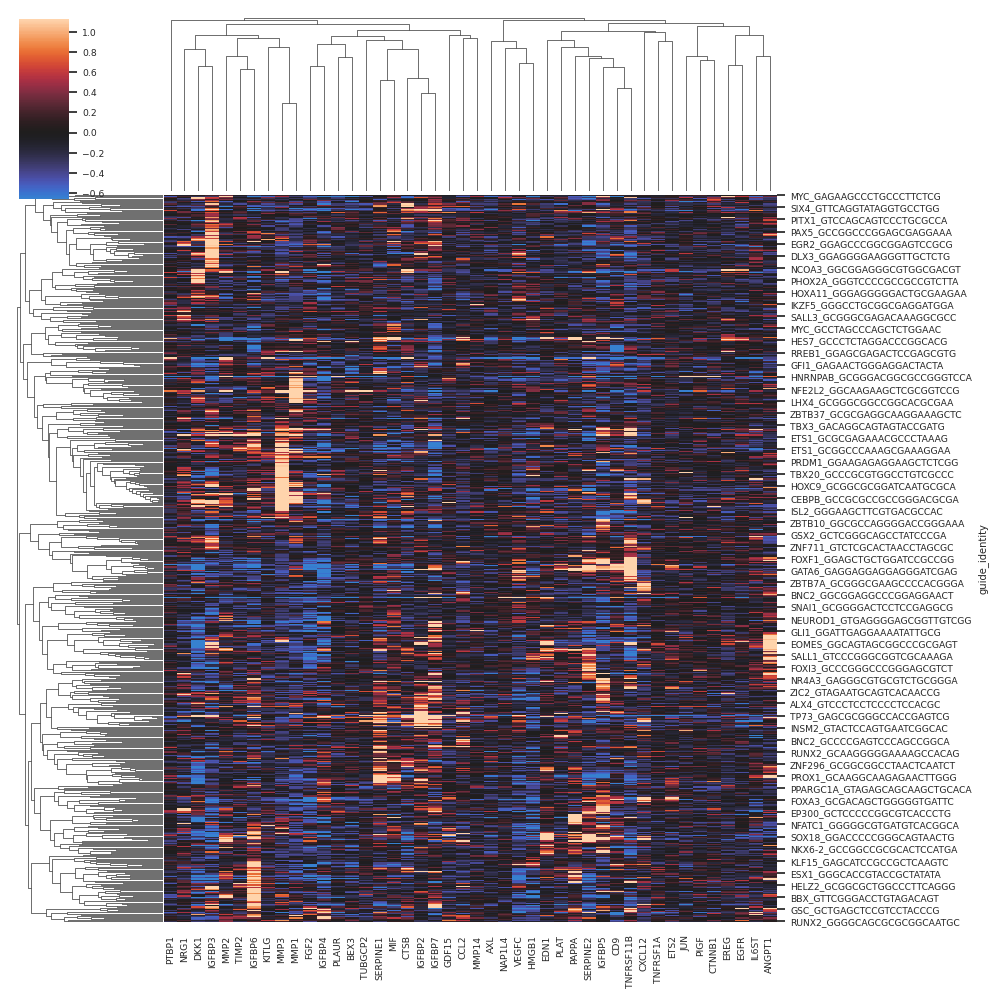

In [417]:
sns.clustermap(senescence_expr.loc[masked_active], robust=True, center=0, method='average', metric='correlation')

In [375]:
senescence_expr['FGF2'].sort_values()

guide_identity
NEUROD2_GTGGCATGCGTCTGCACTGG   -3.357075
KLF5_GCCCTACCTAGCTGCCTTCT      -2.974837
FOXA3_GTCGCCAGGAGACAGACCTC     -2.813518
CASZ1_GTGGGTGGGAAGGATCCGGG     -2.722010
BSX_GGCCGGGAGAGCCAATGACG       -2.574670
                                  ...   
NFE2_GAGGAAACTTGAGCCCGATG       3.238644
GSC_GTTCGCTGAACTCAACCCGC        3.260663
TP73_GTGGCCCCGCCGCGACTCGG       3.284914
MYRF_GCCACGCTCCCGACTCCTGC       3.342276
JUNB_GCCTCCTCGAGCGTGGGGAA       5.240483
Name: FGF2, Length: 661, dtype: float64

In [379]:
fibroblast_low_UMI_mean_pop.matrix.loc['control'].sort_values()

gene_name
ENSG00000160862     -0.000393
ENSG00000149735     -0.000146
ENSG00000204347     -0.000095
ENSG00000259294     -0.000092
ENSG00000274492     -0.000089
                      ...    
ENSG00000197956     50.578812
ENSG00000100097     51.083019
ENSG00000075624     52.659813
ENSG00000156508     55.682823
ENSG00000251562    198.800507
Name: control, Length: 30395, dtype: float64

In [ ]:
# Certainly! I'll provide interpretations for all 58 components based on the genes and perturbations listed.

# Component 0: Cytoskeletal organization and cell differentiation (TUBB2A, STMN2, CNN1). Perturbations (CDX2, GATA4, EOMES) suggest a role in early embryonic development and cell fate determination.

# Component 1: Extracellular matrix (ECM) organization and cell adhesion (FN1, COL1A1, ITGB1). Perturbations (SATB2, TP73, FOXC2, EGR3) involved in ECM remodeling and cell migration.

# Component 2: Mitochondrial function (MT-CO2, MT-CO3, MT-ND4). Perturbations (TP73, GATA2, HES7) suggest a role in mitochondrial biogenesis and energy metabolism regulation.

# Component 3: Ribosome biogenesis and protein synthesis (RPS18, RPS8, RPL12). Perturbations (GATA2, MYCN, MYC) regulate cell growth and proliferation.

# Component 4: Cell migration and adhesion (TMSB4X, CD99, ANXA2). Perturbations (HOXA11, LBX1, NR4A3, IRF4, CDX2) may regulate cell motility in various contexts.

# Component 5: Amino acid and nucleotide metabolism (PSAT1, MTHFD2, PHGDH). Perturbations (GATA6, NSD2, EGR3, HOXA13) may regulate metabolic processes.

# Component 6: ECM remodeling and cell migration (MMP3, COL12A1, MMP2). Perturbations (HOXC11, CEBPB) are involved in these processes.

# Component 7: Protein folding and ER stress response (PPIB, PDIA6, HSP90B1, CALR). Perturbations (JUNB, PDX1, LHX2, HNRNPAB) may regulate this response.

# Component 8: Cell growth and differentiation (PLAGL1, LOXL1, PTK7). Perturbations (ZNF827, JUN, PLAGL1) are involved in these processes.

# Component 9: Antigen processing and presentation, immune response (HLA-B, HLA-C, PSMB9, PSMB8). Perturbation (IRF1) is a key regulator of interferon signaling and immune response.

# Component 10: Cell adhesion and migration (RHOBTB3, ALCAM, TNS3). Perturbations (CDX2, IRF4) may regulate these processes.

# Component 11: Cell differentiation and development (MGP, PMP22, GAS1). Perturbations (SOX9, HHEX, ZBTB7A, HNF1B, FOXC2) are involved in these processes.

# Component 12: ECM organization and cell adhesion (TGM2, COL3A1, TGFBI). Perturbations (CEBPA, HAND1) regulate these processes.

# Component 13: Cell cycle and mitosis (MKI67, NUSAP1, CENPF). Perturbations (PAX5, TBX20, KLF5, NKX3-1, FOXC2) regulate cell cycle progression and proliferation.

# Component 14: Growth factor signaling and angiogenesis (IGFBP3, SULF1, VEGFC). Perturbations (EGR3, TBX5, DLX3) may regulate these processes.

# Component 15: Cell signaling and adhesion (SERPINE2, LGALS3, EDN1). Perturbations (SOX18, FOXE1) are involved in these processes.

# Component 16: ECM organization and collagen synthesis (COL1A2, SPARC, COL1A1, COL3A1). Perturbations (JUNB, PLAGL1, EGR3, BBX) regulate these processes.

# Component 17: RNA processing and transcriptional regulation (HNRNPAB, CYLD, WDR82). Perturbation (HNRNPAB) is directly involved in this process.

# Component 18: Cytoskeletal organization and cell cycle regulation (CRIP1, TUBA1A, LMNA). Perturbations (LYL1, NKX3-1, IRF4, FOXJ1) may regulate these processes.

# Component 19: Cell adhesion and signaling (CLU, MRAS, HEG1). Perturbations (ZBTB7A, SNAI1, PLAG1, GATA2) are involved in these processes.

# Component 20: Cell growth and differentiation (IGFBP2, IGFBP7, MFAP5). Perturbations (ZEB2, TP73) regulate these processes.

# Component 21: Cell signaling and adhesion (TNFRSF11B, CD9, TGFBR2). Perturbations (FOXE1, CEBPA) are involved in these processes.

# Component 22: Cell migration and differentiation (PRSS23, DKK1, MARCKS, SOX4). Perturbations (ETS1, NFATC1, POU4F2, PRDM1, HOXA13) regulate these processes.

# Component 23: Cell adhesion and migration (S100A4, CD9, STMN2). Perturbations (KLF5, FEZF2, CDX2, BARX1) are involved in these processes.

# Component 24: ECM remodeling and growth factor signaling (MMP1, FGF2, COL5A2). Perturbations (PDX1, HES7, CEBPB, JUNB, CEBPA) regulate these processes.

# Component 25: Cell adhesion and metabolism (S100A10, CD9, NT5E, PKM). Perturbations (FOSB, HOXA13, IRF4, FOXA3) may regulate these processes.

# Component 26: ECM organization and cell signaling (CRABP2, ECM1, TIMP1, MMP2). Perturbations (HNRNPAB, ZNF777, OVOL1, NFATC1) are involved in these processes.

# Component 27: Cytoskeletal organization and cell adhesion (ACTC1, ALCAM, SULF1). Perturbations (IRF4, NKX3-1) may regulate these processes.

# Component 28: Oxidative stress response and NRF2 signaling (FTL, FTH1, TXNRD1, NQO1). Perturbations (PRDM1, HOXA13, NFE2L2) support the involvement of NRF2 signaling.

# Component 29: Oxidative stress response and NRF2 signaling (TXN, NQO1, TXNRD1). Perturbations (FOXF1, NFE2L2) further support the role of NRF2 signaling.

# Component 30: Cell signaling and differentiation (SFRP1, ANGPT1, IL11, IGFBP7). Perturbations (NR4A3, TBX21) may regulate these processes.

# Component 31: ECM organization and hypoxia response (CCDC80, GREM1, PLOD2, HIF1A). Perturbations (HES7, EOMES) are involved in these processes.

# Component 32: Cell adhesion and metabolism (KRT18, TXNRD1, THBS2). Perturbations (GATA2, GATA6, GATA4) may regulate these processes.

# Component 33: ECM organization and cell adhesion (CAV1, COL6A1, COL6A2, COL1A1). Perturbations (GFI1, EBF2, NEUROD2) are involved in these processes.

# Component 34: Glycolysis and glucose metabolism (GAPDH, LDHA, ENO1, PGK1). Perturbations (FOXC2, HES7, PAX5, HAND1) may regulate cellular energy metabolism.

# Component 35: Smooth muscle contraction and cytoskeletal organization (ACTA2, TAGLN, TPM2, MYL9). Perturbations (EOMES, FOXC2, GLI1) may regulate these processes.

# Component 36: Cytoskeletal organization and cell adhesion (TPM4, VCL, ACTN4, ACTB). Perturbations (TBX5, PAX3, GLI1, EOMES, FOXC2) are involved in these processes.

# Component 37: Metabolic processes and transcriptional regulation (PGD, FKBP9, TCF4). Perturbations (BCL11A, INSM2, BBX) may regulate these processes.

# Component 38: ECM organization and cell adhesion (ITGBL1, DCN, FBLN1, LUM). Perturbation (FOXE1) is involved in these processes.

# Component 39: ECM organization and TGF-beta signaling (KRT17, HTRA1, TGFB2, TGFBR1). Perturbations (HES7, TP73, FOXC2, TFAP2A) may regulate these processes.

# Component 40: Cell adhesion and differentiation (FST, ANGPT1, FHL2, TNC). Perturbations (ZFPM2, FOXF2, FOXA3, TBX5) are involved in these processes.

# Component 41: Cell signaling and migration (SERPINB7, DKK1, NT5E, ROBO2). Perturbations (JUNB, HOXA13) regulate these processes.

# Component 42: Cell adhesion and vesicle trafficking (IFITM3, TIMP1, CD63, RABAC1). Perturbations (TP73, HHEX, HOXA13, BBX) may regulate these processes.

# Component 43: Cell differentiation and development (PSG5, ALDH1A1, KRT19, CDH2). Perturbations (SOX18, TSHZ1, NFATC1, SMAD1) are involved in these processes.

# Component 44: ECM organization and TGF-beta signaling (COL4A1, COL4A2, TGFB2, ACTA2). Perturbations (NEUROD2, GLI1, TBX21, EOMES) may regulate these processes.

# Component 45: Cell signaling and adhesion (MME, WNT5A, FBLN5, ANXA2). Perturbations (CDX2, DLX2, ALX4, SOX18) are involved in these processes.

# Component 46: Cell differentiation and migration (SOX4, CSRP2, LMO4, CCN2). Perturbations (HOXA13, HOXC11, CDX2) regulate these processes.

# Component 47: Cytoskeletal organization and cell adhesion (FHL1, MYLK, DST). Perturbations (PRDM1, GSC, JUNB) may regulate these processes.

# Component 48: Cell signaling and adhesion (AKAP12, WNT5A, FSTL1, CTNNAL1). Perturbations (HES7, POU4F2) are involved in these processes.

# Component 49: Cell cycle regulation and adhesion (CCND1, HMGA1, ITGB1). Perturbations (EP300, HMX3, BSX, JUN) may regulate these processes.

# Component 50: Cytoskeletal organization and cell adhesion (VIM, LGALS1, ACTB, PFN1). Perturbations (PAX3, NKX3-1, CEBPB, EP300, FOXC2) are involved in these processes.

# Component 51: ECM organization and cell adhesion (COL12A1, LMO7, COLEC12, CALD1). Perturbations (DLX3, HOXC13, BCL11A) may regulate these processes.

# Component 52: RNA processing and transcriptional regulation (ZFAS1, ITSN1, TOP1). Perturbations (HNRNPAB, BBX, HOXC13, GSC) may regulate these processes.

# Component 53: Cell differentiation and signaling (ID1, NR2F1, TCF4, PCDH10). Perturbations (ETS1, NEUROD2, INSM2, IRF1, HOXA11) are involved in these processes.

# Component 54: ECM organization and cell adhesion (SEPTIN11, LOX, ITGA1, IGFBP7). Perturbations (SNAI1, ZNF827, SALL3, BCL11A) may regulate these processes.

# Component 55: Cell signaling and metabolism (DUSP5, RDH10, DTYMK). Perturbations (EOMES, PLAG1, HES7, IKZF5, TP73) are involved in these processes.

# Component 56: Protein folding and degradation (PHB, HSP90B1, VCP, PSMB7). Perturbations (GATA3, FOXF1, HES7) may regulate these processes.

# Component 57: Protein synthesis and folding (HSP90AB1, EIF4A1, NPM1, HSPD1). Perturbations (FOXC2, FOXF1, HES7) are involved in these processes.

# Please note that these interpretations are based on the limited information provided and my current knowledge. Further experimental validation would be necessary to confirm the roles of these gene programs and the effects of the perturbations.